## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRicoMulti.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 1e-2)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e9)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [13]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.
mie_mono_tables = OrderedDict()
for wavelength in [.66, 1.240, 1.640, 2.13]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

#make extinction the density instead of lwc
solvers[.66].medium['cloud'].attrs["density_name"] = "extinction"
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"density" : 'lwc'})
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"extinction" : 'density'})
data = solvers[.66].medium['cloud'].drop_vars("density")
data = data.drop_vars("reff")
data = data.drop_vars("lwc")

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, data
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
    reff=(at3d.transforms.CoordinateTransformScaling(0, 1e-2), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
    #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
    )
)

ValueError: the new name 'lwc' conflicts

In [14]:
print(data)

<xarray.Dataset>
Dimensions:        (x: 32, y: 37, z: 27, stokes_index: 6, legendre_index: 1311,
                    table_index: 22, num_micro: 1)
Coordinates:
    table_index    (num_micro, x, y, z) int64 1 1 1 1 1 2 ... 18 19 20 21 22 22
  * stokes_index   (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * x              (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y              (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z              (z) float64 0.0 0.44 0.48 0.52 0.56 ... 1.32 1.36 1.4 1.44
    veff           (x, y, z) float64 ...
Dimensions without coordinates: legendre_index, num_micro
Data variables:
    ssalb          (x, y, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    legcoef        (stokes_index, legendre_index, table_index) float32 1.0 .....
    phase_weights  (num_micro, x, y, z) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    delx           float64 0.02
    dely           float64 0.02
    interp_method  object .

In [6]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [7]:
regularization_reff = at3d.regularization.SpatialSmoothing(state_gen, "cloud", "reff", 10.0)

# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [8]:
# transform initial physical state to abstract state. 
initial_gridded_extinction = carved_volume.mask.data.astype(float)*0
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
initial_gridded_reff = carved_volume.mask.data.astype(float)*0+10
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))


In [9]:

objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                  'verbose':True, 'maxiter':100, 'init_solution':True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

In [10]:
%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [11]:

optimizer = at3d.optimize.Optimizer(objective_function,prior_fn=regularization_reff, callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
# optimizer = at3d.optimize.Optimizer(objective_function, callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -4.857  0.821E-07    31968     9.00  0.035   [Radiance 2.130 micron]
 ! Iterations:      1     Final Criterion:  0.000014   [Radiance 2.130 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     1  -3.328  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
     1  -3.973  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
     2  -7.327  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
 ! Iterations:      2     Final Criterion:  0.000000   [Radiance 1.640 micron]
     2  -6.284  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
 ! Iterations:      2     Final Criterion:  0.000001   [Radiance 1.240 micron]
     

<Figure size 640x480 with 0 Axes>

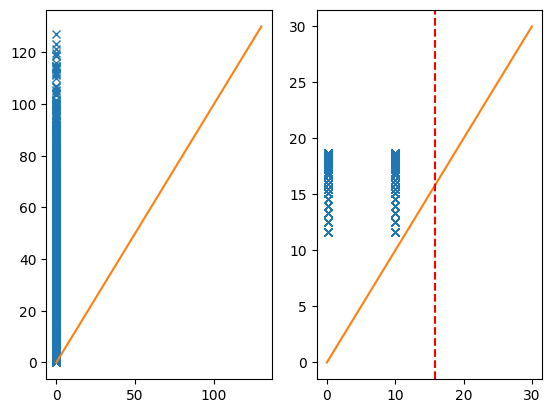

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  7.04156D+05    |proj g|=  1.46539D+01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.631  0.262E+00    31968   213.98  0.836   [Radiance 0.660 micron]
     1  -0.634  0.311E+00    31968   213.98  0.836   [Radiance 1.640 micron]
     1  -0.646  0.312E+00    31968   213.98  0.836   [Radiance 2.130 micron]
     1  -0.632  0.305E+00    31968   213.98  0.836   [Radiance 1.240 micron]
     2  -1.220  0.291E+00    31968   213.98  0.836   [Radiance 0.660 micron]
     2  -1.191  0.355E+00    31968   213.98  0.836   [Radiance 1.640 micron]
     2  -1.18

<Figure size 640x480 with 0 Axes>

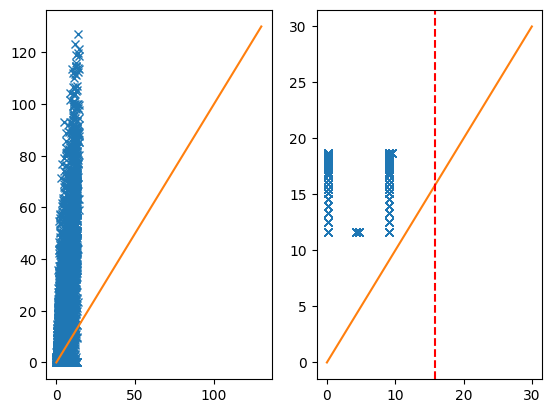


At iterate    1    f=  4.05138D+05    |proj g|=  1.14766D+01


<Figure size 640x480 with 0 Axes>

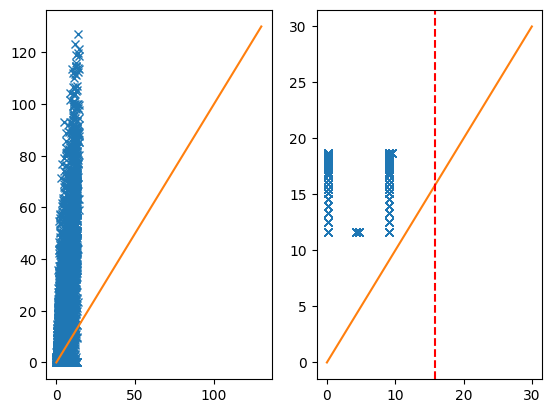

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.627  0.276E+00    31968   168.40  0.658   [Radiance 0.660 micron]
     1  -0.627  0.338E+00    31968   168.40  0.658   [Radiance 1.240 micron]
     1  -0.629  0.376E+00    31968   168.40  0.658   [Radiance 1.640 micron]
     1  -0.640  0.393E+00    31968   168.40  0.658   [Radiance 2.130 micron]
     2  -1.171  0.269E+00    31968   168.40  0.658   [Radiance 0.660 micron]
     2  -1.151  0.329E+00    31968   168.40  0.658   [Radiance 1.240 micron]
     2  -1.136  0.366E+00    31968   168.40  0.658   [Radiance 1.640 micron]
     2  -1.128  0.415E+00    31968   168.40  0.658   [Radiance 2.130 micron]
     3  -1.695  0.266E+00    31968   168.40  0.658   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

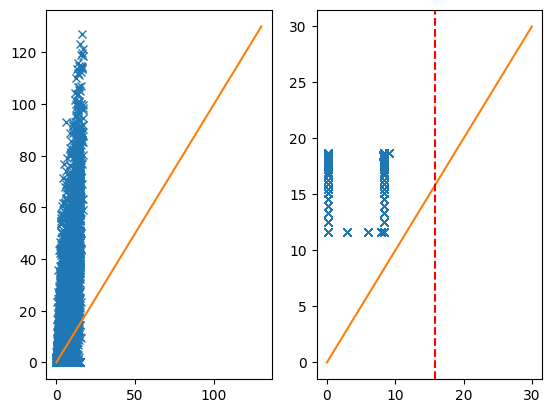


At iterate    2    f=  3.00092D+05    |proj g|=  8.01335D+00


<Figure size 640x480 with 0 Axes>

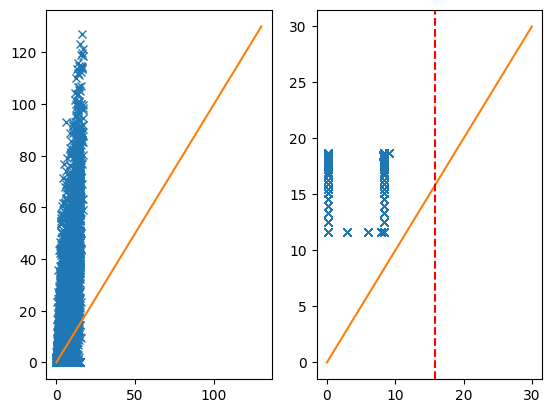

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.628  0.247E+00    31968   157.84  0.617   [Radiance 0.660 micron]
     1  -0.633  0.351E+00    31968   157.84  0.617   [Radiance 2.130 micron]
     1  -0.625  0.269E+00    31968   157.84  0.617   [Radiance 1.240 micron]
     1  -0.624  0.320E+00    31968   157.84  0.617   [Radiance 1.640 micron]
     2  -1.173  0.301E+00    31968   157.84  0.617   [Radiance 0.660 micron]
     2  -1.120  0.390E+00    31968   157.84  0.617   [Radiance 2.130 micron]
     2  -1.149  0.317E+00    31968   157.84  0.617   [Radiance 1.240 micron]
     2  -1.129  0.348E+00    31968   157.84  0.617   [Radiance 1.640 micron]
     3  -1.694  0.323E+00    31968   157.84  0.617   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

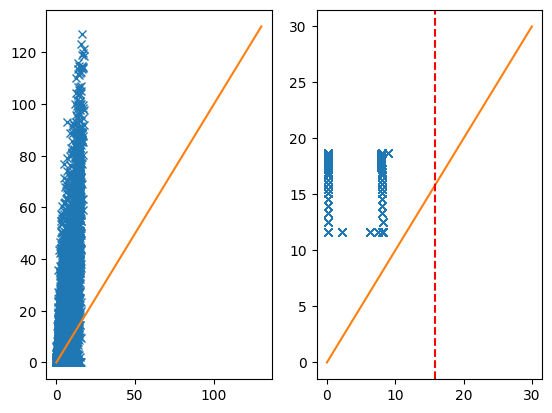


At iterate    3    f=  2.73966D+05    |proj g|=  9.91021D+00


<Figure size 640x480 with 0 Axes>

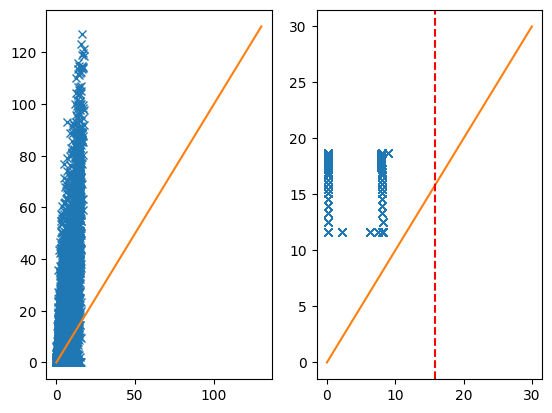

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.627  0.318E+00    31968   164.12  0.641   [Radiance 0.660 micron]
     1  -0.623  0.445E+00    31968   164.12  0.641   [Radiance 1.240 micron]
     1  -0.633  0.247E+00    31968   164.12  0.641   [Radiance 2.130 micron]
     1  -0.622  0.360E+00    31968   164.12  0.641   [Radiance 1.640 micron]
     2  -1.182  0.329E+00    31968   164.12  0.641   [Radiance 0.660 micron]
     2  -1.154  0.481E+00    31968   164.12  0.641   [Radiance 1.240 micron]
     2  -1.141  0.278E+00    31968   164.12  0.641   [Radiance 2.130 micron]
     2  -1.139  0.389E+00    31968   164.12  0.641   [Radiance 1.640 micron]
     3  -1.701  0.330E+00    31968   164.12  0.641   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

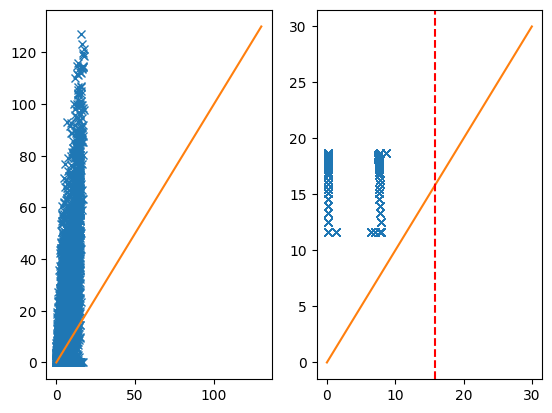

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.628  0.247E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     1  -0.625  0.269E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     1  -0.624  0.320E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     1  -0.633  0.351E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     2  -1.173  0.301E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     2  -1.149  0.317E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     2  -1.129  0.348E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     2  -1.119  0.390E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     3  -1.694  0.323E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

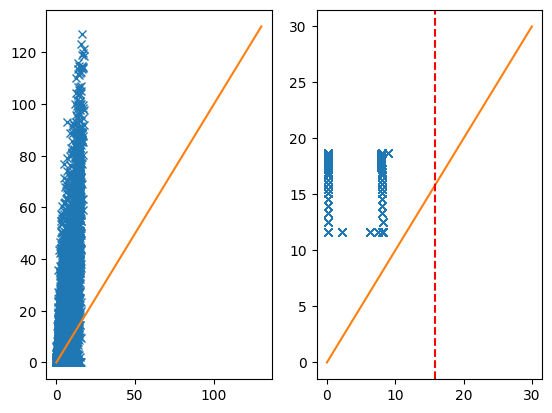

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.623  0.276E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     1  -0.615  0.347E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     1  -0.624  0.309E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     1  -0.613  0.390E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     2  -1.179  0.285E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     2  -1.152  0.370E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     2  -1.122  0.338E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     2  -1.129  0.428E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     3  -1.702  0.286E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

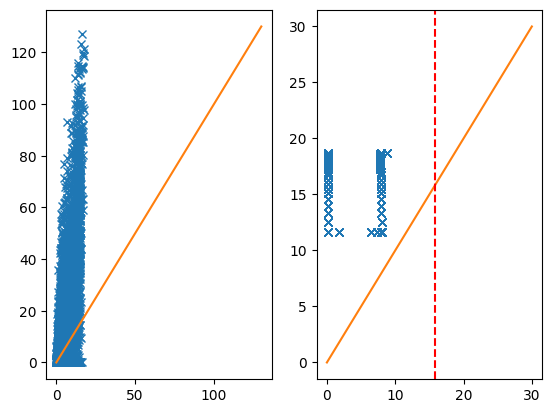

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.624  0.293E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     1  -0.617  0.396E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     1  -0.615  0.394E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     1  -0.627  0.273E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     2  -1.154  0.426E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     2  -1.182  0.302E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     2  -1.133  0.432E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     2  -1.130  0.296E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     3  -1.692  0.430E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

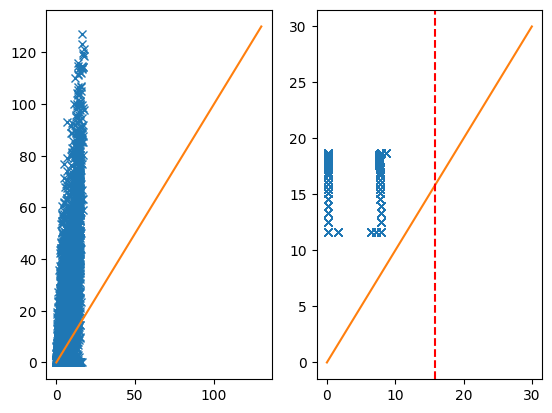

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.626  0.312E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     1  -0.620  0.440E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     1  -0.619  0.369E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     1  -0.632  0.252E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     2  -1.184  0.323E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     2  -1.155  0.476E+00    31968   177.69  0.694   [Radiance 1.240 micron]
     2  -1.141  0.283E+00    31968   177.69  0.694   [Radiance 2.130 micron]
     2  -1.140  0.401E+00    31968   177.69  0.694   [Radiance 1.640 micron]
     3  -1.703  0.324E+00    31968   177.69  0.694   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

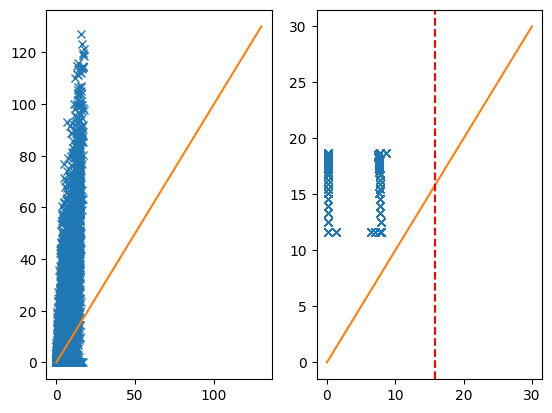


At iterate    4    f=  2.50432D+05    |proj g|=  5.19084D+00


<Figure size 640x480 with 0 Axes>

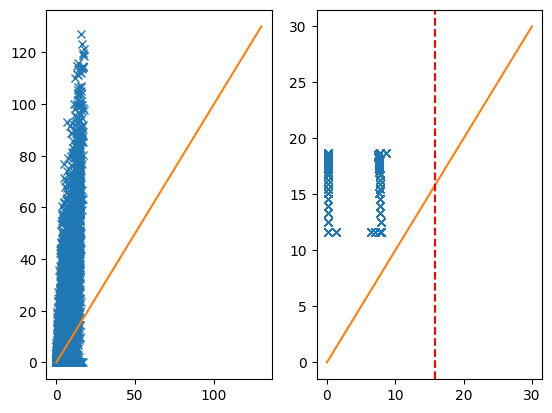

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.638  0.267E+00    31968   152.46  0.596   [Radiance 1.240 micron]
     1  -0.653  0.450E+00    31968   152.46  0.596   [Radiance 2.130 micron]
     1  -0.634  0.514E+00    31968   152.46  0.596   [Radiance 0.660 micron]
     1  -0.641  0.313E+00    31968   152.46  0.596   [Radiance 1.640 micron]
     2  -1.178  0.283E+00    31968   152.46  0.596   [Radiance 1.240 micron]
     2  -1.161  0.533E+00    31968   152.46  0.596   [Radiance 2.130 micron]
     2  -1.184  0.547E+00    31968   152.46  0.596   [Radiance 0.660 micron]
     2  -1.166  0.365E+00    31968   152.46  0.596   [Radiance 1.640 micron]
     3  -1.718  0.294E+00    31968   152.46  0.596   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

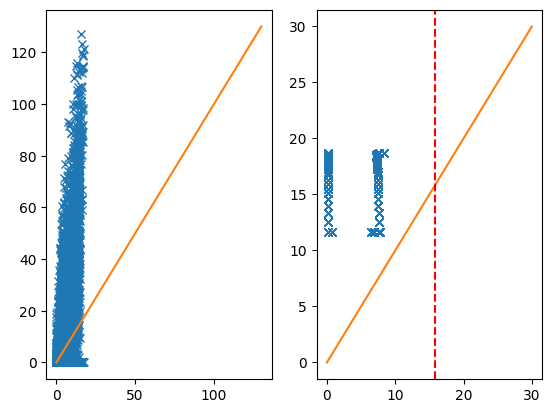


At iterate    5    f=  2.31695D+05    |proj g|=  4.85478D+00


<Figure size 640x480 with 0 Axes>

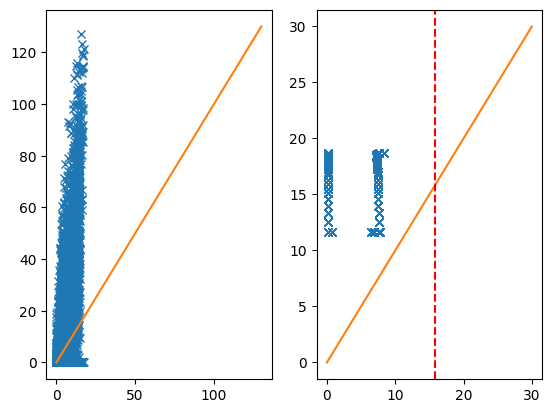

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.648  0.520E+00    31968   155.86  0.609   [Radiance 0.660 micron]
     1  -0.645  0.574E+00    31968   155.86  0.609   [Radiance 1.240 micron]
     1  -0.648  0.614E+00    31968   155.86  0.609   [Radiance 2.130 micron]
     1  -0.641  0.605E+00    31968   155.86  0.609   [Radiance 1.640 micron]
     2  -1.227  0.553E+00    31968   155.86  0.609   [Radiance 0.660 micron]
     2  -1.205  0.628E+00    31968   155.86  0.609   [Radiance 1.240 micron]
     2  -1.173  0.687E+00    31968   155.86  0.609   [Radiance 2.130 micron]
     2  -1.183  0.664E+00    31968   155.86  0.609   [Radiance 1.640 micron]
     3  -1.774  0.552E+00    31968   155.86  0.609   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

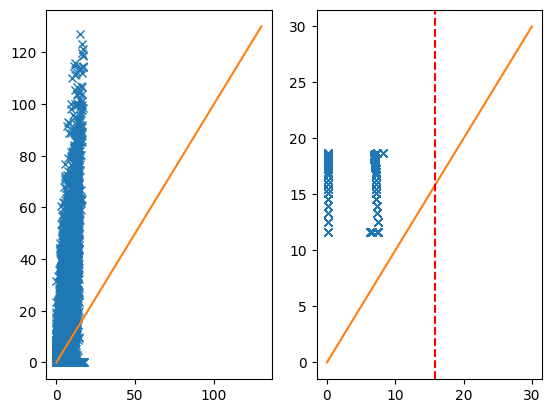


At iterate    6    f=  2.13620D+05    |proj g|=  4.42366D+00


<Figure size 640x480 with 0 Axes>

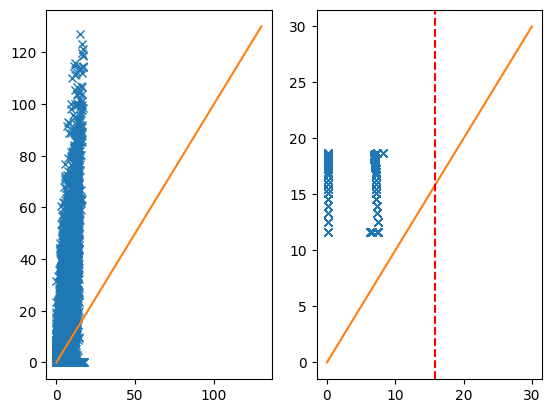

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.658  0.506E+00    31968   150.53  0.588   [Radiance 0.660 micron]
     1  -0.647  0.571E+00    31968   150.53  0.588   [Radiance 1.640 micron]
     1  -0.652  0.559E+00    31968   150.53  0.588   [Radiance 1.240 micron]
     1  -0.652  0.578E+00    31968   150.53  0.588   [Radiance 2.130 micron]
     2  -1.250  0.537E+00    31968   150.53  0.588   [Radiance 0.660 micron]
     2  -1.203  0.640E+00    31968   150.53  0.588   [Radiance 1.640 micron]
     2  -1.226  0.612E+00    31968   150.53  0.588   [Radiance 1.240 micron]
     2  -1.192  0.643E+00    31968   150.53  0.588   [Radiance 2.130 micron]
     3  -1.799  0.536E+00    31968   150.53  0.588   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

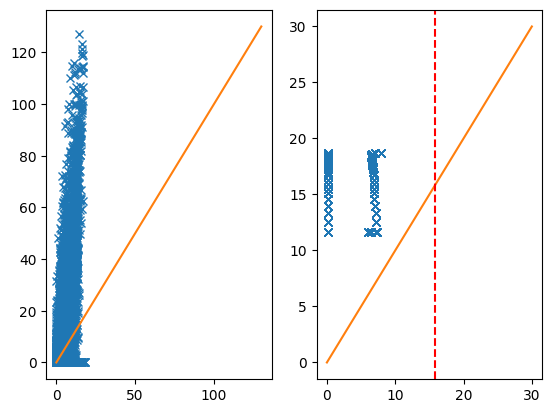


At iterate    7    f=  2.04433D+05    |proj g|=  4.76667D+00


<Figure size 640x480 with 0 Axes>

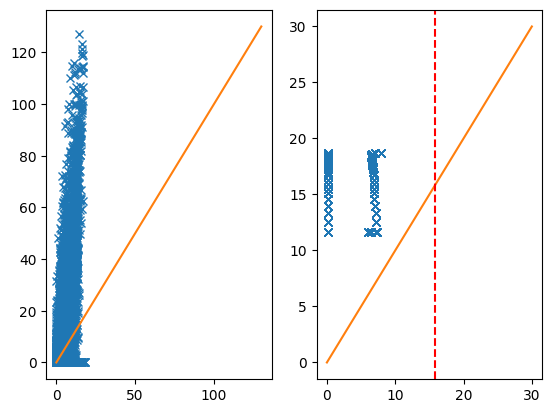

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.658  0.531E+00    31968   146.42  0.572   [Radiance 2.130 micron]
     1  -0.661  0.546E+00    31968   146.42  0.572   [Radiance 1.240 micron]
     1  -0.669  0.491E+00    31968   146.42  0.572   [Radiance 0.660 micron]
     1  -0.654  0.554E+00    31968   146.42  0.572   [Radiance 1.640 micron]
     2  -1.206  0.609E+00    31968   146.42  0.572   [Radiance 2.130 micron]
     2  -1.267  0.520E+00    31968   146.42  0.572   [Radiance 0.660 micron]
     2  -1.218  0.622E+00    31968   146.42  0.572   [Radiance 1.640 micron]
     2  -1.242  0.597E+00    31968   146.42  0.572   [Radiance 1.240 micron]
     3  -1.819  0.520E+00    31968   146.42  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

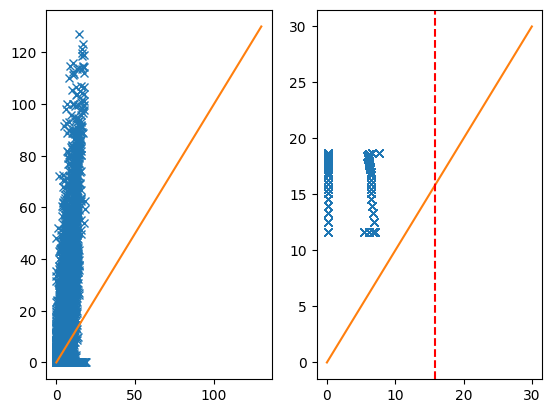


At iterate    8    f=  1.92131D+05    |proj g|=  4.75571D+00


<Figure size 640x480 with 0 Axes>

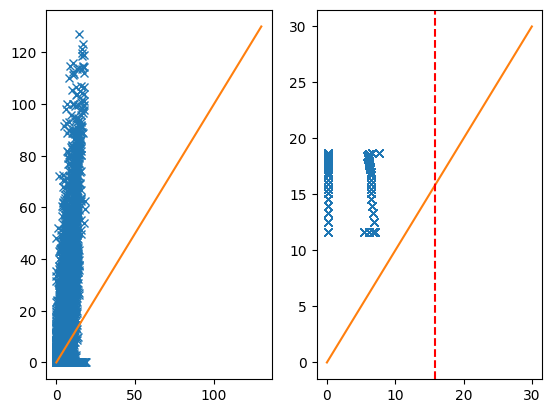

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.675  0.480E+00    31968   145.52  0.568   [Radiance 0.660 micron]
     1  -0.655  0.506E+00    31968   145.52  0.568   [Radiance 2.130 micron]
     1  -0.662  0.536E+00    31968   145.52  0.568   [Radiance 1.240 micron]
     1  -0.654  0.540E+00    31968   145.52  0.568   [Radiance 1.640 micron]
     2  -1.271  0.508E+00    31968   145.52  0.568   [Radiance 0.660 micron]
     2  -1.202  0.590E+00    31968   145.52  0.568   [Radiance 2.130 micron]
     2  -1.218  0.605E+00    31968   145.52  0.568   [Radiance 1.640 micron]
     2  -1.243  0.587E+00    31968   145.52  0.568   [Radiance 1.240 micron]
     3  -1.825  0.508E+00    31968   145.52  0.568   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

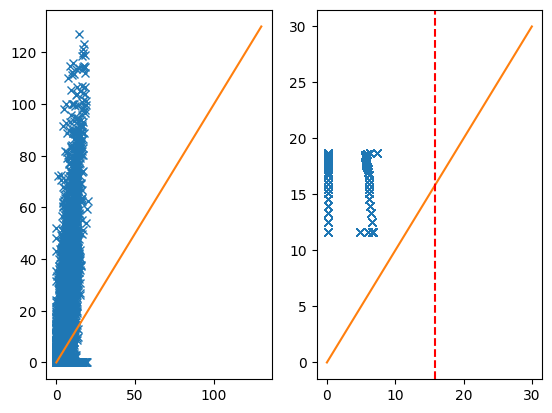


At iterate    9    f=  1.79700D+05    |proj g|=  4.48925D+00


<Figure size 640x480 with 0 Axes>

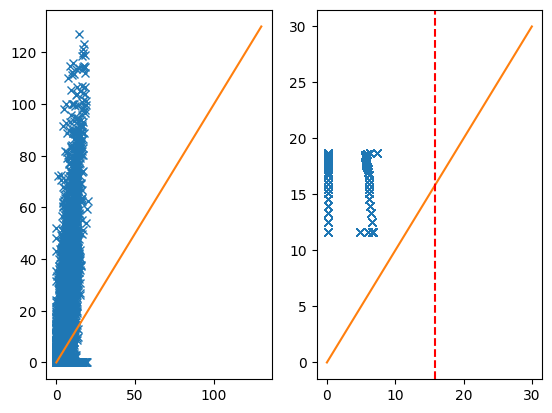

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.464E+00    31968   139.66  0.546   [Radiance 0.660 micron]
     1  -0.660  0.493E+00    31968   139.66  0.546   [Radiance 2.130 micron]
     1  -0.669  0.521E+00    31968   139.66  0.546   [Radiance 1.240 micron]
     1  -0.663  0.510E+00    31968   139.66  0.546   [Radiance 1.640 micron]
     2  -1.201  0.579E+00    31968   139.66  0.546   [Radiance 2.130 micron]
     2  -1.273  0.492E+00    31968   139.66  0.546   [Radiance 0.660 micron]
     2  -1.222  0.572E+00    31968   139.66  0.546   [Radiance 1.640 micron]
     2  -1.244  0.571E+00    31968   139.66  0.546   [Radiance 1.240 micron]
     3  -1.783  0.602E+00    31968   139.66  0.546   [Radiance 2.130 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

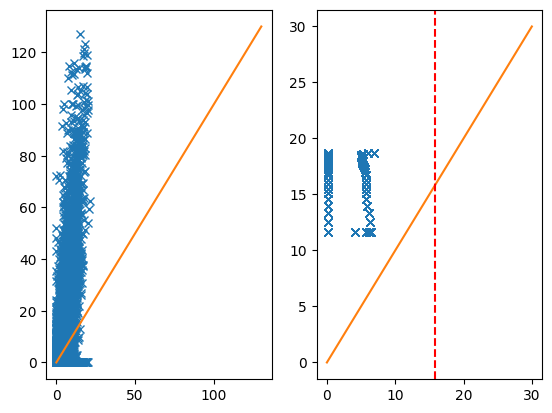


At iterate   10    f=  1.62148D+05    |proj g|=  5.70958D+00


<Figure size 640x480 with 0 Axes>

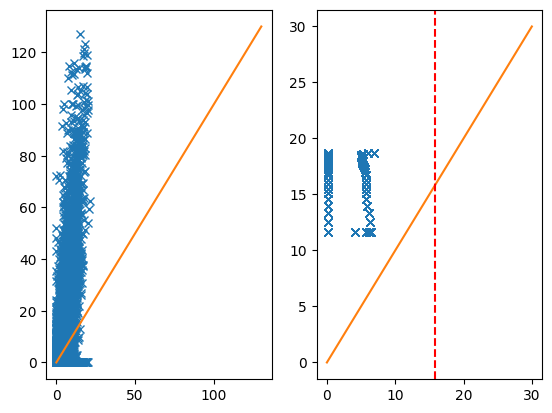

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.674  0.438E+00    31968   141.15  0.551   [Radiance 0.660 micron]
     1  -0.659  0.477E+00    31968   141.15  0.551   [Radiance 1.240 micron]
     1  -0.652  0.465E+00    31968   141.15  0.551   [Radiance 1.640 micron]
     1  -0.641  0.488E+00    31968   141.15  0.551   [Radiance 2.130 micron]
     2  -1.268  0.466E+00    31968   141.15  0.551   [Radiance 0.660 micron]
     2  -1.234  0.521E+00    31968   141.15  0.551   [Radiance 1.240 micron]
     2  -1.171  0.584E+00    31968   141.15  0.551   [Radiance 2.130 micron]
     2  -1.212  0.524E+00    31968   141.15  0.551   [Radiance 1.640 micron]
     3  -1.827  0.472E+00    31968   141.15  0.551   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

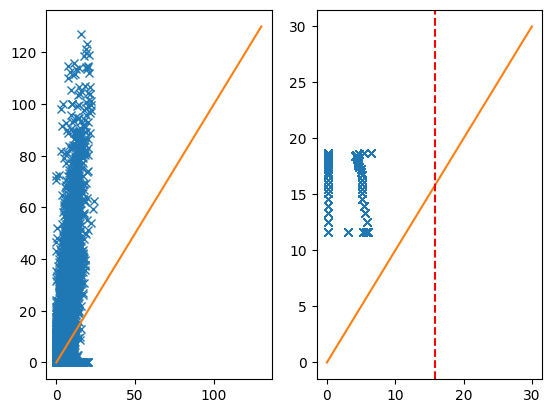


At iterate   11    f=  1.41624D+05    |proj g|=  5.03170D+00


<Figure size 640x480 with 0 Axes>

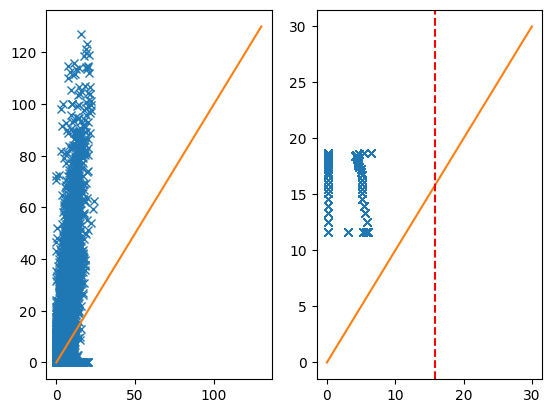

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.674  0.410E+00    31968   137.32  0.536   [Radiance 0.660 micron]
     1  -0.662  0.419E+00    31968   137.32  0.536   [Radiance 1.240 micron]
     1  -0.653  0.420E+00    31968   137.32  0.536   [Radiance 1.640 micron]
     1  -0.628  0.356E+00    31968   137.32  0.536   [Radiance 2.130 micron]
     2  -1.262  0.449E+00    31968   137.32  0.536   [Radiance 0.660 micron]
     2  -1.232  0.484E+00    31968   137.32  0.536   [Radiance 1.240 micron]
     2  -1.208  0.509E+00    31968   137.32  0.536   [Radiance 1.640 micron]
     2  -1.131  0.446E+00    31968   137.32  0.536   [Radiance 2.130 micron]
     3  -1.820  0.455E+00    31968   137.32  0.536   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

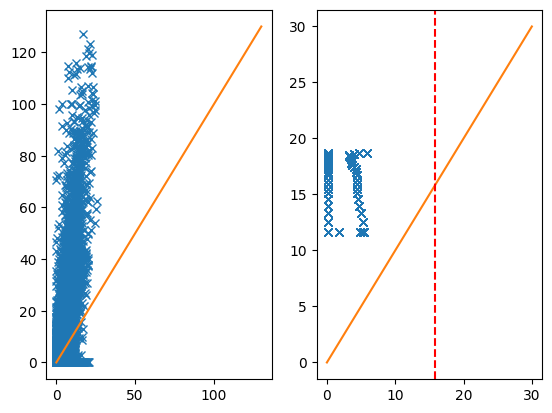


At iterate   12    f=  1.18988D+05    |proj g|=  7.41623D+00


<Figure size 640x480 with 0 Axes>

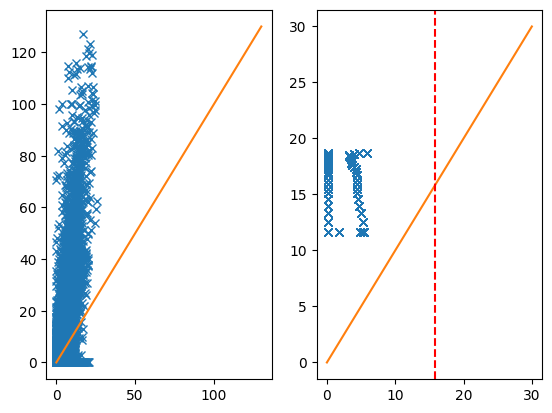

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.674  0.444E+00    31968   141.59  0.553   [Radiance 0.660 micron]
     1  -0.663  0.336E+00    31968   141.59  0.553   [Radiance 1.240 micron]
     1  -0.615  0.313E+00    31968   141.59  0.553   [Radiance 2.130 micron]
     1  -0.649  0.275E+00    31968   141.59  0.553   [Radiance 1.640 micron]
     2  -1.258  0.499E+00    31968   141.59  0.553   [Radiance 0.660 micron]
     2  -1.231  0.369E+00    31968   141.59  0.553   [Radiance 1.240 micron]
     2  -1.087  0.365E+00    31968   141.59  0.553   [Radiance 2.130 micron]
     2  -1.189  0.307E+00    31968   141.59  0.553   [Radiance 1.640 micron]
     3  -1.813  0.515E+00    31968   141.59  0.553   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

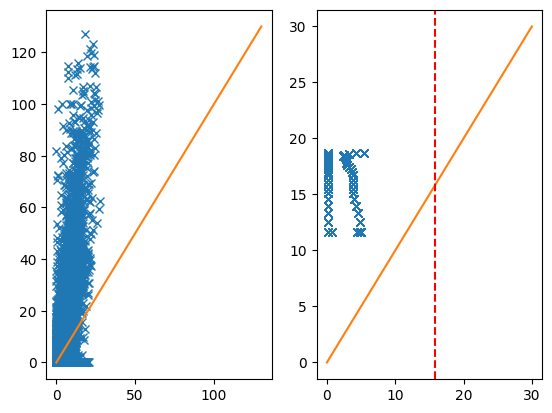


At iterate   13    f=  1.04233D+05    |proj g|=  7.63690D+00


<Figure size 640x480 with 0 Axes>

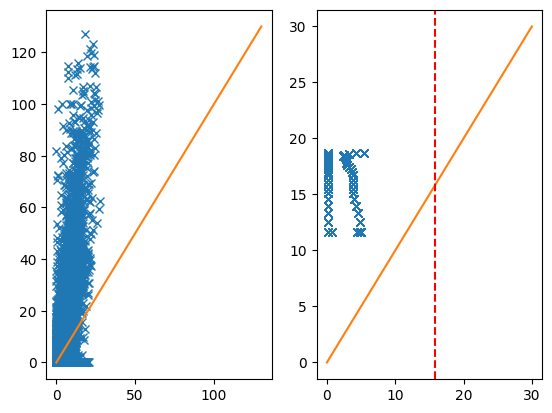

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.212E+00    31968   142.90  0.558   [Radiance 0.660 micron]
     1  -0.669  0.262E+00    31968   142.90  0.558   [Radiance 1.240 micron]
     1  -0.650  0.307E+00    31968   142.90  0.558   [Radiance 1.640 micron]
     1  -0.613  0.320E+00    31968   142.90  0.558   [Radiance 2.130 micron]
     2  -1.257  0.229E+00    31968   142.90  0.558   [Radiance 0.660 micron]
     2  -1.230  0.290E+00    31968   142.90  0.558   [Radiance 1.240 micron]
     2  -1.172  0.353E+00    31968   142.90  0.558   [Radiance 1.640 micron]
     2  -1.069  0.363E+00    31968   142.90  0.558   [Radiance 2.130 micron]
     3  -1.810  0.230E+00    31968   142.90  0.558   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

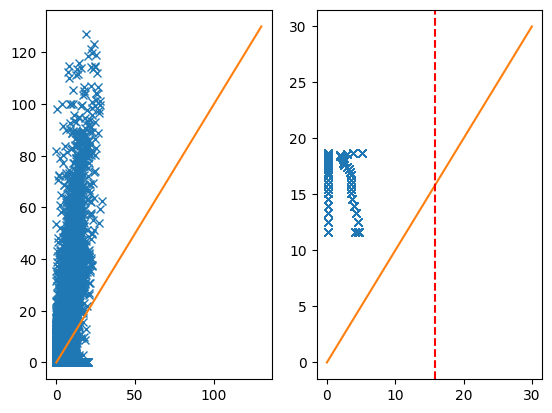


At iterate   14    f=  9.51554D+04    |proj g|=  8.28490D+00


<Figure size 640x480 with 0 Axes>

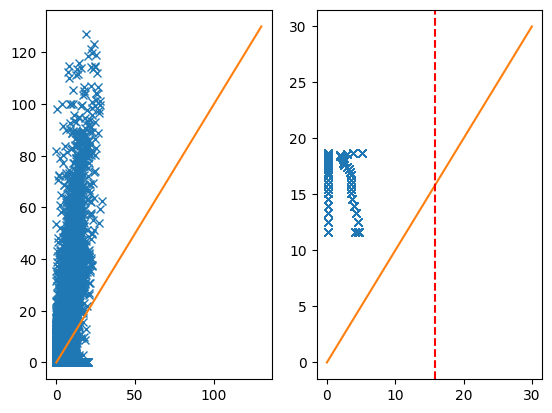

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.684  0.230E+00    31968   139.78  0.546   [Radiance 0.660 micron]
     1  -0.668  0.310E+00    31968   139.78  0.546   [Radiance 1.240 micron]
     1  -0.642  0.322E+00    31968   139.78  0.546   [Radiance 1.640 micron]
     1  -0.601  0.309E+00    31968   139.78  0.546   [Radiance 2.130 micron]
     2  -1.256  0.250E+00    31968   139.78  0.546   [Radiance 0.660 micron]
     2  -1.212  0.358E+00    31968   139.78  0.546   [Radiance 1.240 micron]
     2  -1.143  0.361E+00    31968   139.78  0.546   [Radiance 1.640 micron]
     2  -1.048  0.363E+00    31968   139.78  0.546   [Radiance 2.130 micron]
     3  -1.800  0.252E+00    31968   139.78  0.546   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

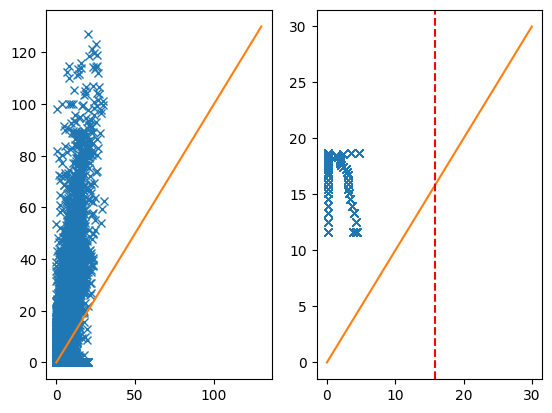


At iterate   15    f=  8.62094D+04    |proj g|=  9.40274D+00


<Figure size 640x480 with 0 Axes>

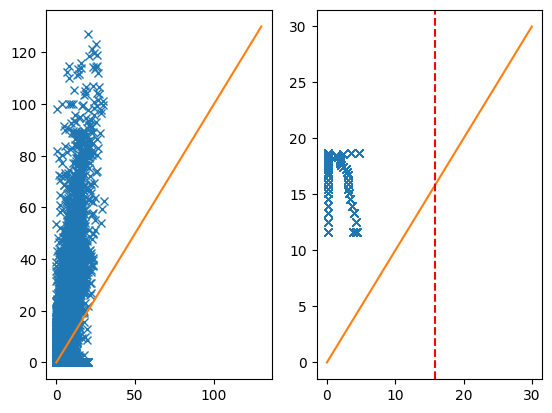

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   137.44  0.537   [Radiance 0.660 micron]
     1  -0.654  0.323E+00    31968   137.44  0.537   [Radiance 1.240 micron]
     1  -0.621  0.295E+00    31968   137.44  0.537   [Radiance 1.640 micron]
     1  -0.586  0.269E+00    31968   137.44  0.537   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   137.44  0.537   [Radiance 0.660 micron]
     2  -1.176  0.362E+00    31968   137.44  0.537   [Radiance 1.240 micron]
     2  -1.112  0.352E+00    31968   137.44  0.537   [Radiance 1.640 micron]
     2  -1.053  0.324E+00    31968   137.44  0.537   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   137.44  0.537   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

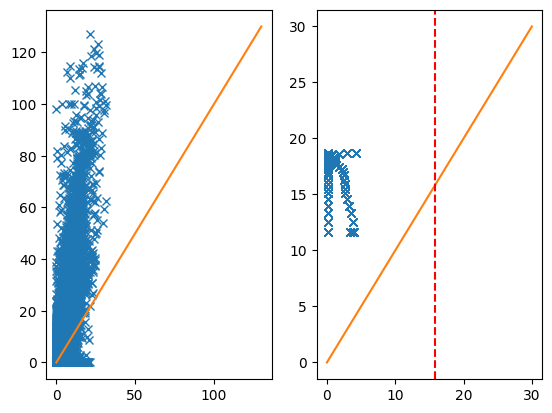


At iterate   16    f=  8.21475D+04    |proj g|=  1.15960D+01


<Figure size 640x480 with 0 Axes>

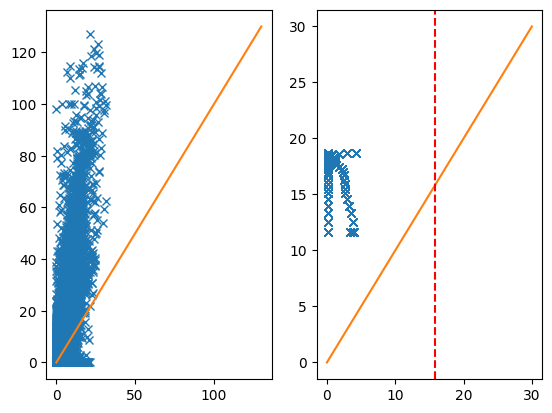

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.645  0.308E+00    31968   136.87  0.535   [Radiance 1.240 micron]
     1  -0.664  0.319E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     1  -0.624  0.285E+00    31968   136.87  0.535   [Radiance 1.640 micron]
     1  -0.607  0.245E+00    31968   136.87  0.535   [Radiance 2.130 micron]
     2  -1.194  0.359E+00    31968   136.87  0.535   [Radiance 1.240 micron]
     2  -1.202  0.357E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.088  0.276E+00    31968   136.87  0.535   [Radiance 2.130 micron]
     2  -1.140  0.334E+00    31968   136.87  0.535   [Radiance 1.640 micron]
     3  -1.655  0.380E+00    31968   136.87  0.535   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

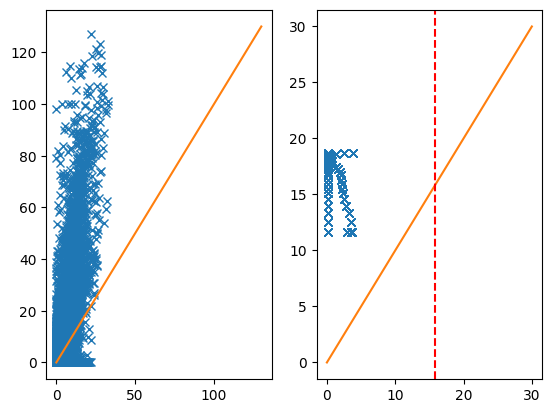

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.648  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.611  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.573  0.268E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.171  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.105  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.048  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.723  0.380E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

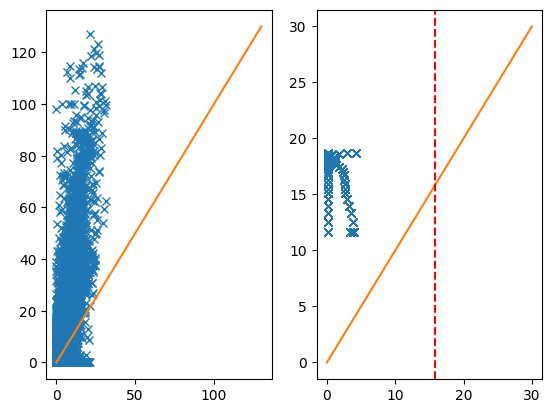

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.654  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.583  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     1  -0.620  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.176  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.111  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.051  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

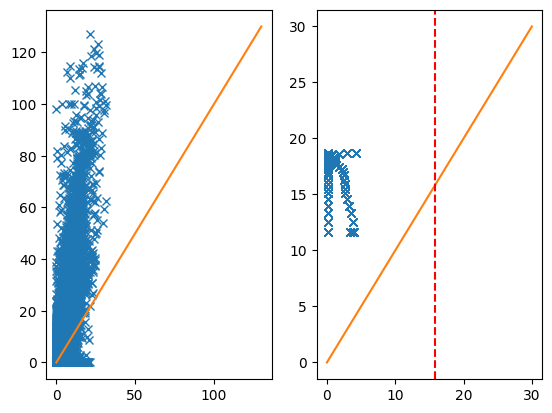

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.614  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.651  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.576  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.107  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.173  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.048  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

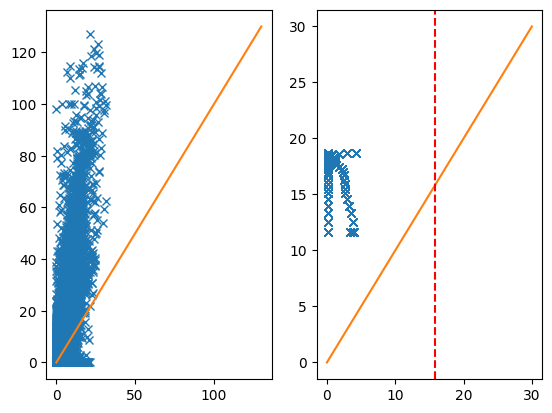

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

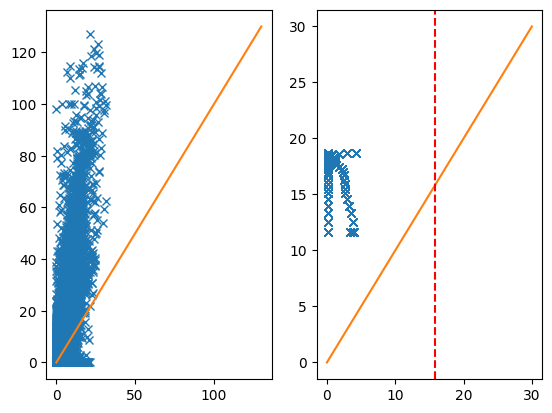


At iterate   17    f=  8.21453D+04    |proj g|=  7.44735D+00


<Figure size 640x480 with 0 Axes>

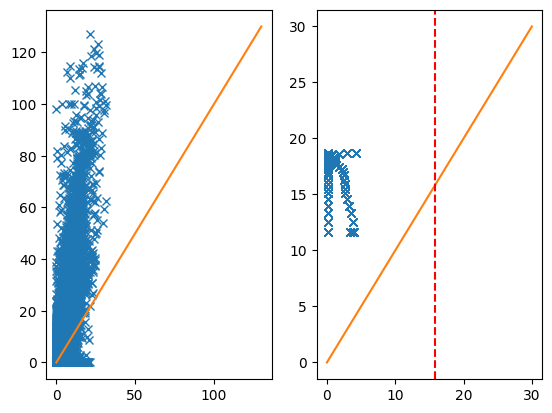

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   148.18  0.579   [Radiance 0.660 micron]
     1  -0.650  0.322E+00    31968   148.18  0.579   [Radiance 1.240 micron]
     1  -0.577  0.268E+00    31968   148.18  0.579   [Radiance 2.130 micron]
     1  -0.613  0.295E+00    31968   148.18  0.579   [Radiance 1.640 micron]
     2  -1.233  0.362E+00    31968   148.18  0.579   [Radiance 0.660 micron]
     2  -1.172  0.361E+00    31968   148.18  0.579   [Radiance 1.240 micron]
     2  -1.050  0.323E+00    31968   148.18  0.579   [Radiance 2.130 micron]
     2  -1.107  0.352E+00    31968   148.18  0.579   [Radiance 1.640 micron]
     3  -1.722  0.380E+00    31968   148.18  0.579   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

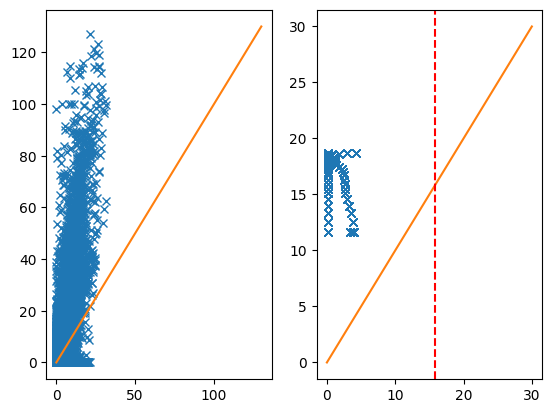

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   152.24  0.595   [Radiance 0.660 micron]
     1  -0.616  0.295E+00    31968   152.24  0.595   [Radiance 1.640 micron]
     1  -0.652  0.323E+00    31968   152.24  0.595   [Radiance 1.240 micron]
     1  -0.579  0.269E+00    31968   152.24  0.595   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   152.24  0.595   [Radiance 0.660 micron]
     2  -1.108  0.352E+00    31968   152.24  0.595   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   152.24  0.595   [Radiance 2.130 micron]
     2  -1.174  0.362E+00    31968   152.24  0.595   [Radiance 1.240 micron]
     3  -1.724  0.381E+00    31968   152.24  0.595   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

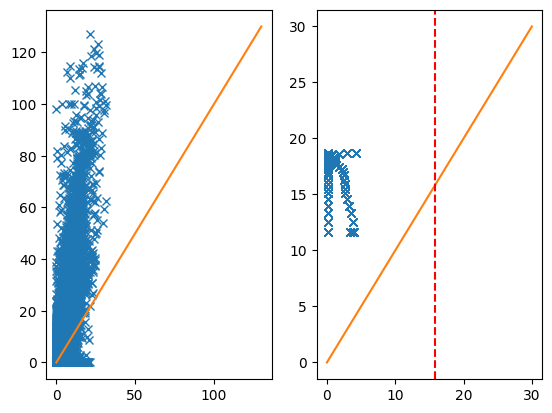

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   152.23  0.595   [Radiance 0.660 micron]
     1  -0.652  0.323E+00    31968   152.23  0.595   [Radiance 1.240 micron]
     1  -0.617  0.295E+00    31968   152.23  0.595   [Radiance 1.640 micron]
     1  -0.579  0.269E+00    31968   152.23  0.595   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   152.23  0.595   [Radiance 0.660 micron]
     2  -1.175  0.362E+00    31968   152.23  0.595   [Radiance 1.240 micron]
     2  -1.109  0.352E+00    31968   152.23  0.595   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   152.23  0.595   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   152.23  0.595   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

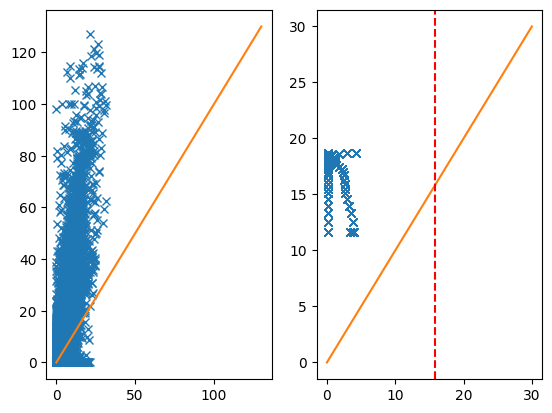

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.653  0.323E+00    31968   152.19  0.595   [Radiance 1.240 micron]
     1  -0.678  0.310E+00    31968   152.19  0.594   [Radiance 0.660 micron]
     1  -0.579  0.269E+00    31968   152.19  0.595   [Radiance 2.130 micron]
     1  -0.617  0.295E+00    31968   152.19  0.595   [Radiance 1.640 micron]
     2  -1.175  0.362E+00    31968   152.19  0.595   [Radiance 1.240 micron]
     2  -1.234  0.362E+00    31968   152.19  0.594   [Radiance 0.660 micron]
     2  -1.049  0.324E+00    31968   152.19  0.595   [Radiance 2.130 micron]
     2  -1.109  0.352E+00    31968   152.19  0.595   [Radiance 1.640 micron]
     3  -1.581  0.373E+00    31968   152.19  0.595   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

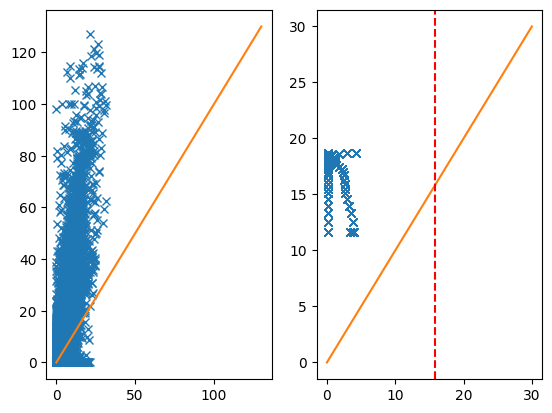

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

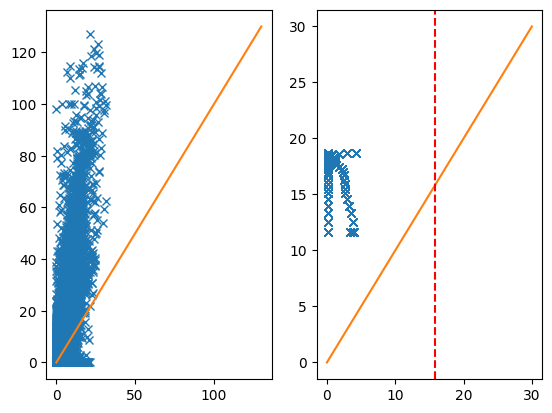

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

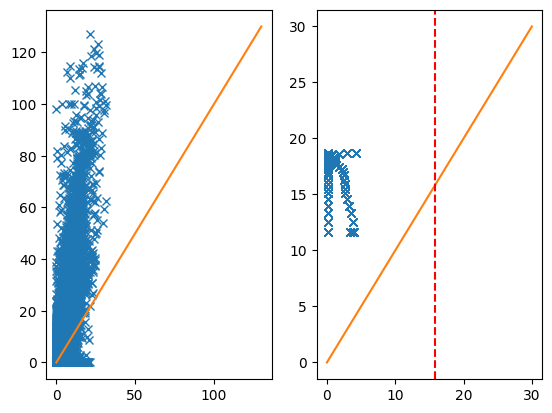

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.581  0.373E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

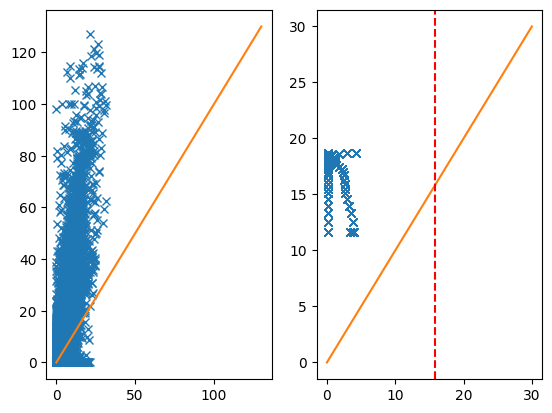

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

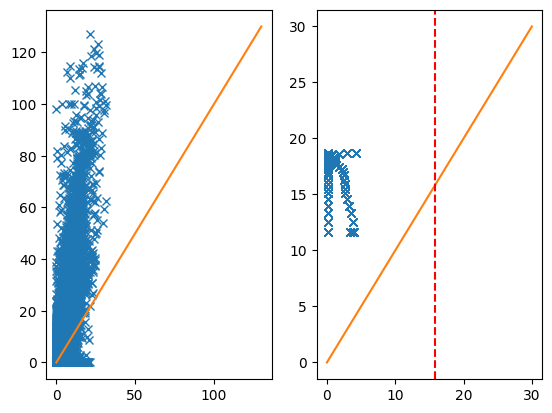

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     3  -1.724  0.381E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

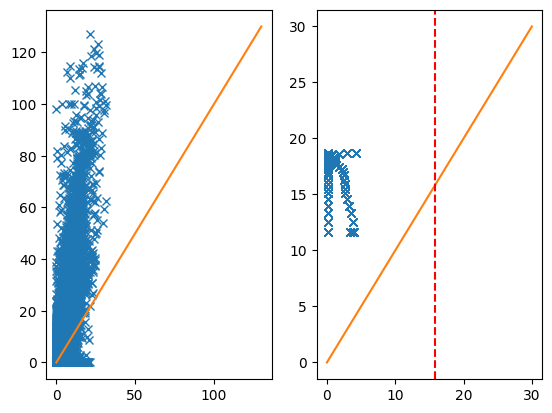

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.310E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     1  -0.653  0.323E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     1  -0.617  0.295E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     1  -0.579  0.269E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     2  -1.175  0.362E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     2  -1.234  0.362E+00    31968   151.93  0.593   [Radiance 0.660 micron]
     2  -1.109  0.352E+00    31968   151.93  0.593   [Radiance 1.640 micron]
     2  -1.049  0.324E+00    31968   151.93  0.593   [Radiance 2.130 micron]
     3  -1.581  0.373E+00    31968   151.93  0.593   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

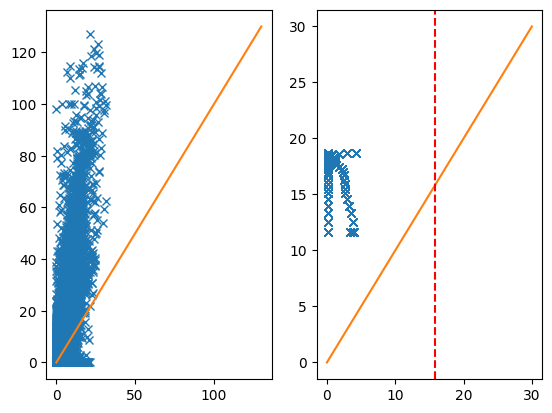


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.697  0.312E+00    31968    89.13  0.348   [Radiance 0.660 micron]
     1  -0.679  0.318E+00    31968    89.13  0.348   [Radiance 1.240 micron]
     1  -0.657  0.324E+00    31968    89.13  0.348   [Radiance 1.640 micron]
     1  -0.634  0.303E+00    31968    89.13  0.348   [Radiance 2.130 micron]
     2  -1.258  0.343E+00    31968    89.13  0.348   [Radiance 0.660 micron]
     2  -1.186  0.355E+00    31968    89.13  0.348   [Radiance 1.240 micron]
     2  -1.115  0.368E+00    31968    89.13  0.348   [Radiance 1.640 micron]
     2  -1.066  0.357E+00    31968    89.13  0.348   [Radiance 2.130 micron]
     3  -1.750  0.360E+00    31968    89.13  0.348   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

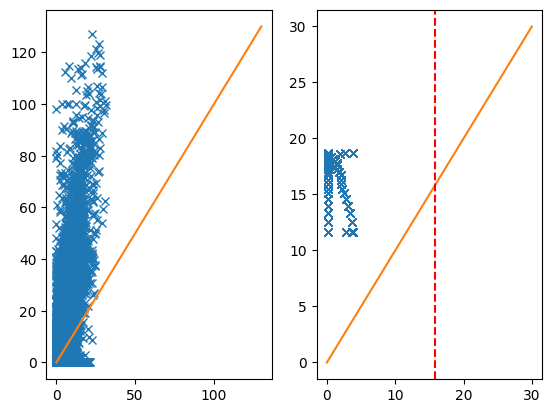

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.676  0.299E+00    31968   156.15  0.610   [Radiance 0.660 micron]
     1  -0.650  0.326E+00    31968   156.15  0.610   [Radiance 1.240 micron]
     1  -0.615  0.294E+00    31968   156.15  0.610   [Radiance 1.640 micron]
     1  -0.580  0.270E+00    31968   156.15  0.610   [Radiance 2.130 micron]
     2  -1.235  0.349E+00    31968   156.15  0.610   [Radiance 0.660 micron]
     2  -1.174  0.365E+00    31968   156.15  0.610   [Radiance 1.240 micron]
     2  -1.109  0.351E+00    31968   156.15  0.610   [Radiance 1.640 micron]
     2  -1.053  0.326E+00    31968   156.15  0.610   [Radiance 2.130 micron]
     3  -1.727  0.366E+00    31968   156.15  0.610   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

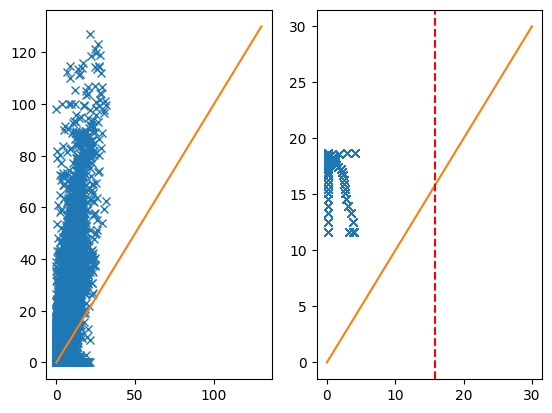


At iterate   18    f=  7.92500D+04    |proj g|=  3.89284D+00


<Figure size 640x480 with 0 Axes>

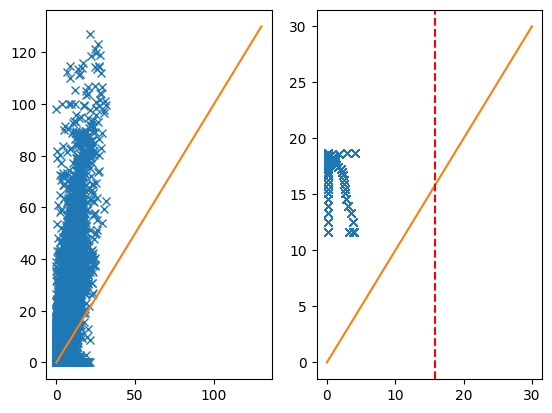

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.695  0.302E+00    31968    84.66  0.331   [Radiance 0.660 micron]
     1  -0.676  0.321E+00    31968    84.66  0.331   [Radiance 1.240 micron]
     1  -0.636  0.306E+00    31968    84.66  0.331   [Radiance 2.130 micron]
     1  -0.656  0.324E+00    31968    84.66  0.331   [Radiance 1.640 micron]
     2  -1.185  0.358E+00    31968    84.66  0.331   [Radiance 1.240 micron]
     2  -1.258  0.332E+00    31968    84.66  0.331   [Radiance 0.660 micron]
     2  -1.065  0.359E+00    31968    84.66  0.331   [Radiance 2.130 micron]
     2  -1.113  0.369E+00    31968    84.66  0.331   [Radiance 1.640 micron]
     3  -1.746  0.348E+00    31968    84.66  0.331   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

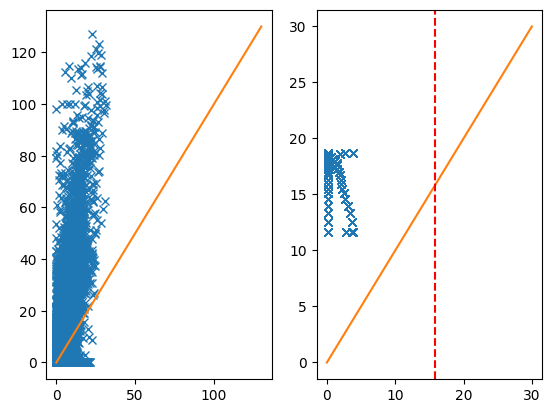

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.676  0.285E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     1  -0.650  0.326E+00    31968   156.54  0.612   [Radiance 1.240 micron]
     1  -0.615  0.295E+00    31968   156.54  0.612   [Radiance 1.640 micron]
     1  -0.582  0.271E+00    31968   156.54  0.612   [Radiance 2.130 micron]
     2  -1.236  0.330E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     2  -1.175  0.366E+00    31968   156.54  0.612   [Radiance 1.240 micron]
     2  -1.109  0.352E+00    31968   156.54  0.612   [Radiance 1.640 micron]
     2  -1.056  0.327E+00    31968   156.54  0.612   [Radiance 2.130 micron]
     3  -1.728  0.345E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

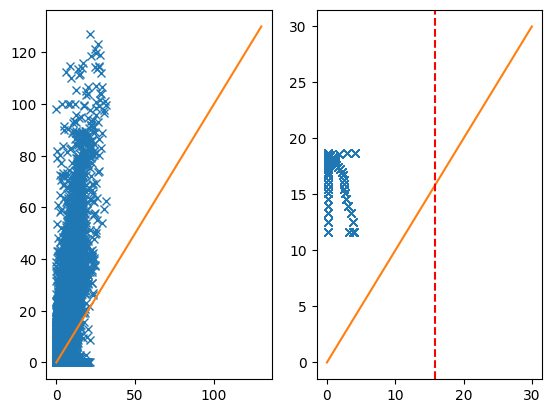

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.676  0.243E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     1  -0.649  0.324E+00    31968   156.54  0.611   [Radiance 1.240 micron]
     1  -0.616  0.307E+00    31968   156.54  0.611   [Radiance 1.640 micron]
     1  -0.587  0.292E+00    31968   156.54  0.611   [Radiance 2.130 micron]
     2  -1.242  0.260E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     2  -1.176  0.361E+00    31968   156.54  0.611   [Radiance 1.240 micron]
     2  -1.111  0.351E+00    31968   156.54  0.611   [Radiance 1.640 micron]
     2  -1.067  0.345E+00    31968   156.54  0.611   [Radiance 2.130 micron]
     3  -1.746  0.261E+00    31968   156.54  0.612   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

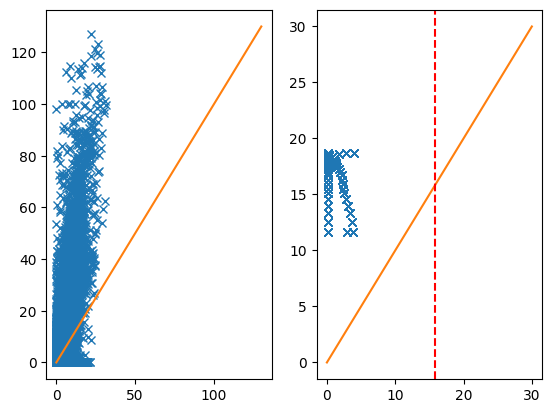


At iterate   19    f=  7.65596D+04    |proj g|=  4.95082D+00


<Figure size 640x480 with 0 Axes>

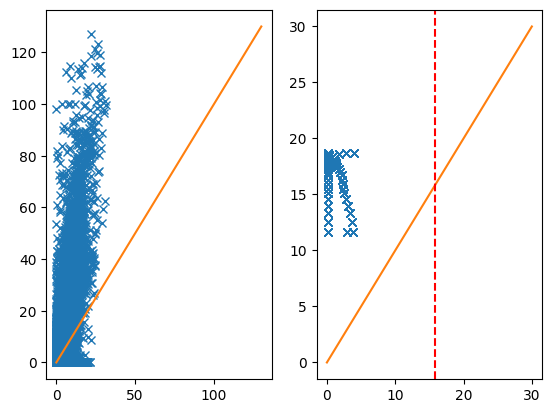

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.666  0.305E+00    31968    84.46  0.330   [Radiance 1.240 micron]
     1  -0.692  0.315E+00    31968    84.46  0.330   [Radiance 0.660 micron]
     1  -0.644  0.387E+00    31968    84.46  0.330   [Radiance 2.130 micron]
     1  -0.651  0.339E+00    31968    84.46  0.330   [Radiance 1.640 micron]
     2  -1.162  0.337E+00    31968    84.46  0.330   [Radiance 1.240 micron]
     2  -1.249  0.354E+00    31968    84.46  0.330   [Radiance 0.660 micron]
     2  -1.101  0.447E+00    31968    84.46  0.330   [Radiance 2.130 micron]
     2  -1.112  0.376E+00    31968    84.46  0.330   [Radiance 1.640 micron]
     3  -1.547  0.355E+00    31968    84.46  0.330   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

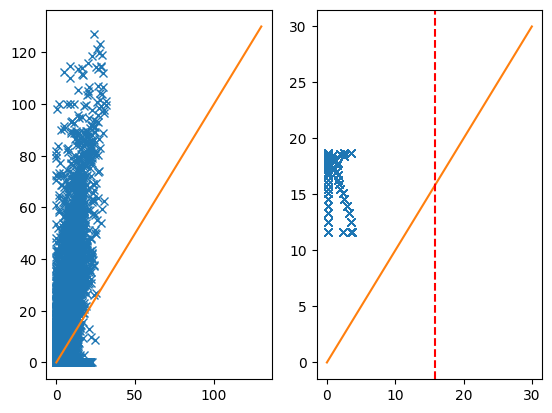


At iterate   20    f=  5.73648D+04    |proj g|=  7.51102D+00


<Figure size 640x480 with 0 Axes>

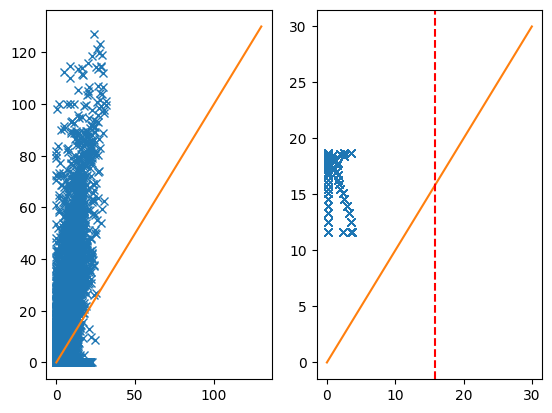

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.667  0.311E+00    31968   121.57  0.475   [Radiance 0.660 micron]
     1  -0.615  0.325E+00    31968   121.57  0.475   [Radiance 1.640 micron]
     1  -0.637  0.301E+00    31968   121.57  0.475   [Radiance 1.240 micron]
     1  -0.604  0.331E+00    31968   121.57  0.475   [Radiance 2.130 micron]
     2  -1.218  0.348E+00    31968   121.57  0.475   [Radiance 0.660 micron]
     2  -1.103  0.366E+00    31968   121.57  0.475   [Radiance 1.640 micron]
     2  -1.138  0.342E+00    31968   121.57  0.475   [Radiance 1.240 micron]
     2  -1.114  0.392E+00    31968   121.57  0.475   [Radiance 2.130 micron]
     3  -1.670  0.359E+00    31968   121.57  0.475   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

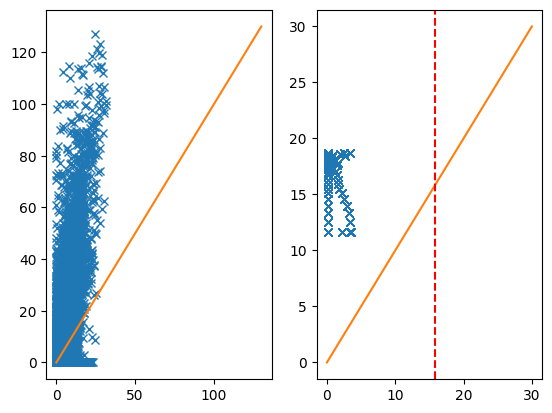


At iterate   21    f=  5.01206D+04    |proj g|=  4.74202D+00


<Figure size 640x480 with 0 Axes>

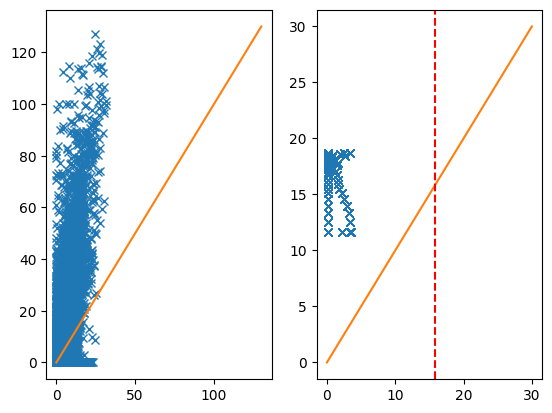

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.667  0.306E+00    31968   137.72  0.538   [Radiance 0.660 micron]
     1  -0.639  0.301E+00    31968   137.72  0.538   [Radiance 1.240 micron]
     1  -0.619  0.320E+00    31968   137.72  0.538   [Radiance 1.640 micron]
     1  -0.611  0.306E+00    31968   137.72  0.538   [Radiance 2.130 micron]
     2  -1.216  0.345E+00    31968   137.72  0.538   [Radiance 0.660 micron]
     2  -1.141  0.348E+00    31968   137.72  0.538   [Radiance 1.240 micron]
     2  -1.114  0.367E+00    31968   137.72  0.538   [Radiance 1.640 micron]
     2  -1.134  0.366E+00    31968   137.72  0.538   [Radiance 2.130 micron]
     3  -1.676  0.368E+00    31968   137.72  0.538   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

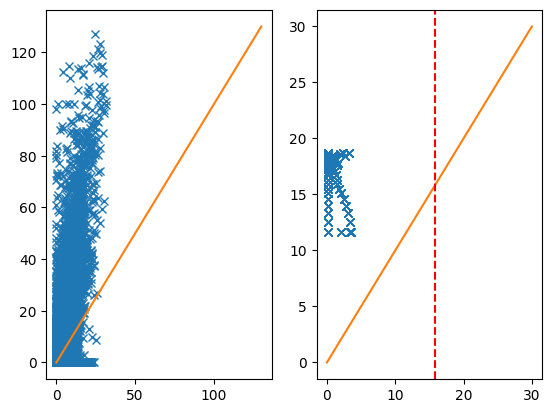


At iterate   22    f=  4.81912D+04    |proj g|=  4.51283D+00


<Figure size 640x480 with 0 Axes>

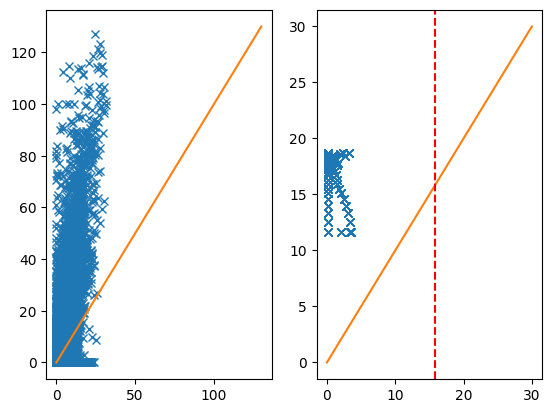

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.679  0.285E+00    31968   129.35  0.505   [Radiance 0.660 micron]
     1  -0.649  0.342E+00    31968   129.35  0.505   [Radiance 1.240 micron]
     1  -0.627  0.333E+00    31968   129.35  0.505   [Radiance 1.640 micron]
     1  -0.623  0.329E+00    31968   129.35  0.505   [Radiance 2.130 micron]
     2  -1.232  0.343E+00    31968   129.35  0.505   [Radiance 0.660 micron]
     2  -1.148  0.376E+00    31968   129.35  0.505   [Radiance 1.240 micron]
     2  -1.129  0.396E+00    31968   129.35  0.505   [Radiance 1.640 micron]
     2  -1.164  0.374E+00    31968   129.35  0.505   [Radiance 2.130 micron]
     3  -1.693  0.367E+00    31968   129.35  0.505   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

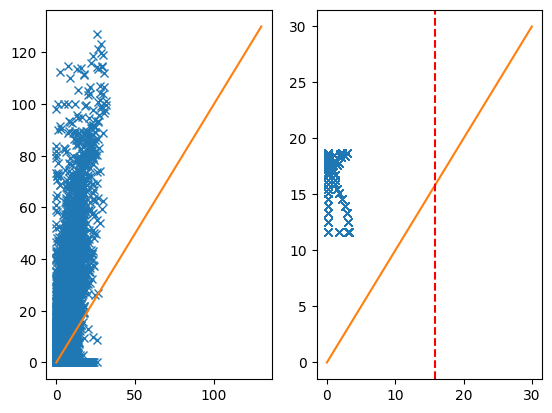

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.668  0.300E+00    31968   145.40  0.568   [Radiance 0.660 micron]
     1  -0.641  0.305E+00    31968   145.40  0.568   [Radiance 1.240 micron]
     1  -0.609  0.304E+00    31968   145.40  0.568   [Radiance 2.130 micron]
     1  -0.619  0.317E+00    31968   145.40  0.568   [Radiance 1.640 micron]
     2  -1.219  0.349E+00    31968   145.40  0.568   [Radiance 0.660 micron]
     2  -1.144  0.351E+00    31968   145.40  0.568   [Radiance 1.240 micron]
     2  -1.142  0.365E+00    31968   145.40  0.568   [Radiance 2.130 micron]
     2  -1.118  0.367E+00    31968   145.40  0.568   [Radiance 1.640 micron]
     3  -1.683  0.372E+00    31968   145.40  0.568   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

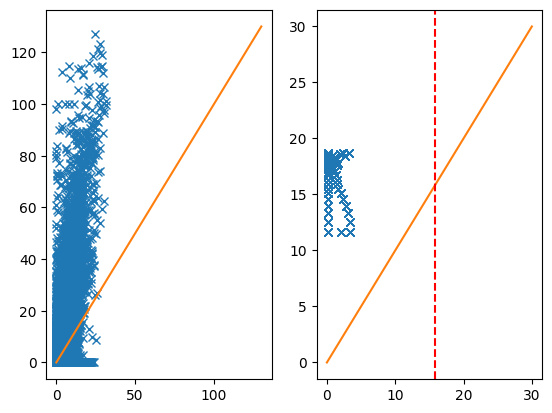


At iterate   23    f=  4.73470D+04    |proj g|=  3.28651D+00


<Figure size 640x480 with 0 Axes>

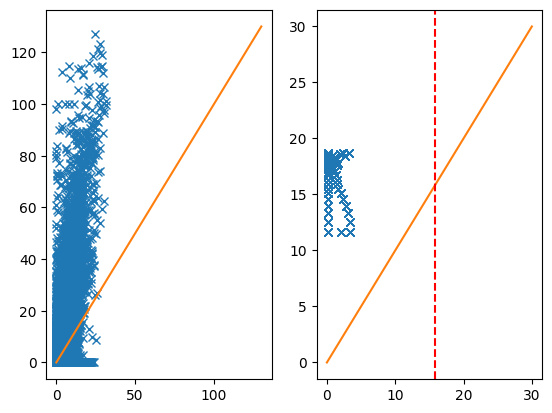

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.676  0.260E+00    31968   114.49  0.447   [Radiance 0.660 micron]
     1  -0.663  0.385E+00    31968   114.49  0.447   [Radiance 1.240 micron]
     1  -0.659  0.387E+00    31968   114.49  0.447   [Radiance 1.640 micron]
     1  -0.677  0.336E+00    31968   114.49  0.447   [Radiance 2.130 micron]
     2  -1.199  0.282E+00    31968   114.49  0.447   [Radiance 0.660 micron]
     2  -1.193  0.467E+00    31968   114.49  0.447   [Radiance 1.240 micron]
     2  -1.251  0.389E+00    31968   114.49  0.447   [Radiance 2.130 micron]
     2  -1.216  0.468E+00    31968   114.49  0.447   [Radiance 1.640 micron]
     3  -1.634  0.287E+00    31968   114.49  0.447   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

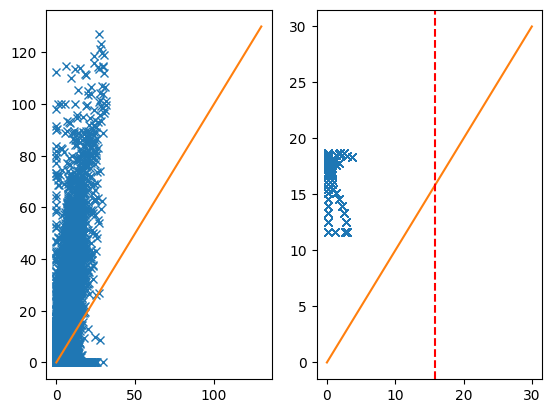

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.643  0.310E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.670  0.295E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.621  0.318E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     1  -0.612  0.303E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.220  0.351E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.146  0.353E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.122  0.367E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     2  -1.147  0.364E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     3  -1.684  0.375E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

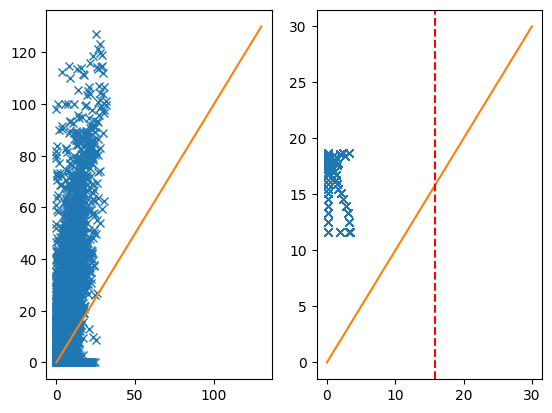

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.680  0.264E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.656  0.330E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.639  0.332E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     1  -0.638  0.351E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     2  -1.218  0.307E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.163  0.386E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.205  0.380E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     3  -1.669  0.326E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

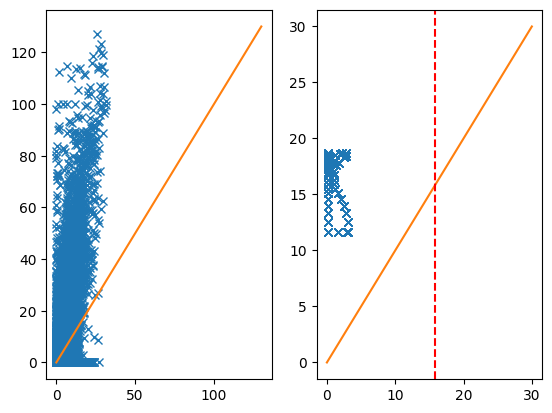


At iterate   24    f=  4.70407D+04    |proj g|=  3.69207D+00


<Figure size 640x480 with 0 Axes>

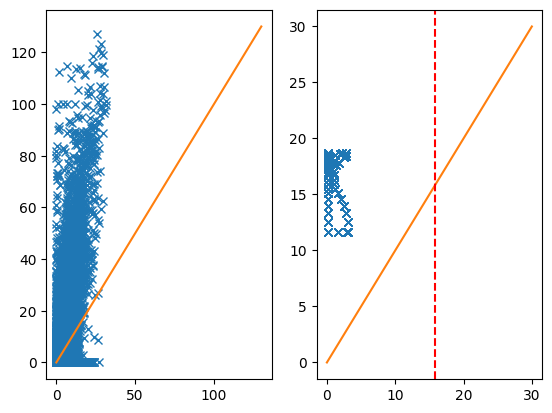

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.680  0.335E+00    31968   112.12  0.438   [Radiance 0.660 micron]
     1  -0.681  0.411E+00    31968   112.12  0.438   [Radiance 1.240 micron]
     1  -0.688  0.390E+00    31968   112.12  0.438   [Radiance 1.640 micron]
     1  -0.703  0.352E+00    31968   112.12  0.438   [Radiance 2.130 micron]
     2  -1.193  0.379E+00    31968   112.12  0.438   [Radiance 0.660 micron]
     2  -1.251  0.496E+00    31968   112.12  0.438   [Radiance 1.240 micron]
     2  -1.286  0.412E+00    31968   112.12  0.438   [Radiance 2.130 micron]
     2  -1.271  0.467E+00    31968   112.12  0.438   [Radiance 1.640 micron]
     3  -1.634  0.391E+00    31968   112.12  0.438   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

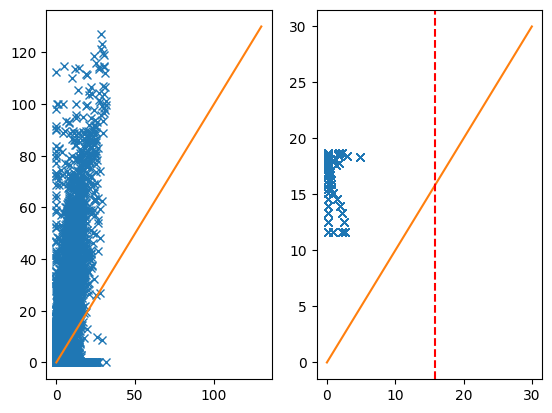

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.680  0.263E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     1  -0.645  0.331E+00    31968   150.99  0.590   [Radiance 2.130 micron]
     1  -0.659  0.330E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     1  -0.643  0.353E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     2  -1.217  0.303E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     2  -1.211  0.379E+00    31968   150.99  0.590   [Radiance 2.130 micron]
     2  -1.168  0.389E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     2  -1.167  0.425E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     3  -1.668  0.321E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

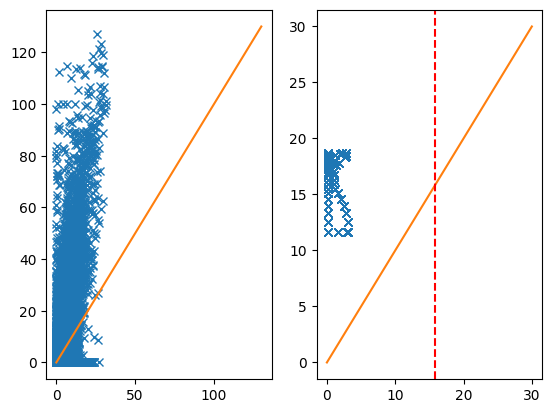

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.264E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     1  -0.643  0.332E+00    31968   150.99  0.590   [Radiance 2.130 micron]
     1  -0.641  0.352E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     1  -0.657  0.330E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     2  -1.217  0.307E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     2  -1.208  0.379E+00    31968   150.99  0.590   [Radiance 2.130 micron]
     2  -1.164  0.423E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     2  -1.165  0.386E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     3  -1.669  0.325E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

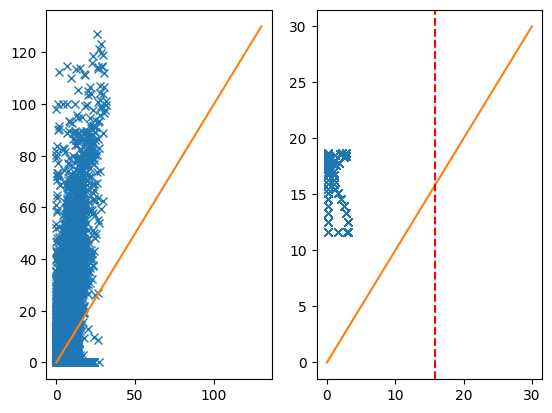

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.656  0.330E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     1  -0.680  0.264E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     1  -0.640  0.332E+00    31968   150.97  0.590   [Radiance 2.130 micron]
     2  -1.164  0.386E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     2  -1.218  0.307E+00    31968   150.99  0.590   [Radiance 0.660 micron]
     2  -1.206  0.380E+00    31968   150.97  0.590   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   150.99  0.590   [Radiance 1.640 micron]
     3  -1.585  0.413E+00    31968   150.99  0.590   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

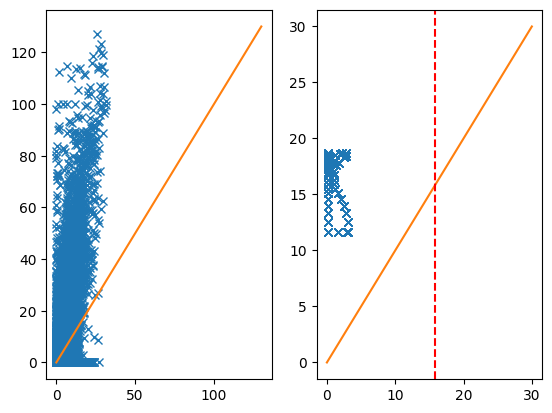

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.680  0.264E+00    31968   150.97  0.590   [Radiance 0.660 micron]
     1  -0.639  0.332E+00    31968   150.91  0.590   [Radiance 2.130 micron]
     1  -0.656  0.330E+00    31968   150.93  0.590   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   150.93  0.590   [Radiance 1.640 micron]
     2  -1.218  0.307E+00    31968   150.97  0.590   [Radiance 0.660 micron]
     2  -1.163  0.386E+00    31968   150.93  0.590   [Radiance 1.240 micron]
     2  -1.205  0.380E+00    31968   150.91  0.590   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   150.93  0.590   [Radiance 1.640 micron]
     3  -1.669  0.326E+00    31968   150.97  0.590   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

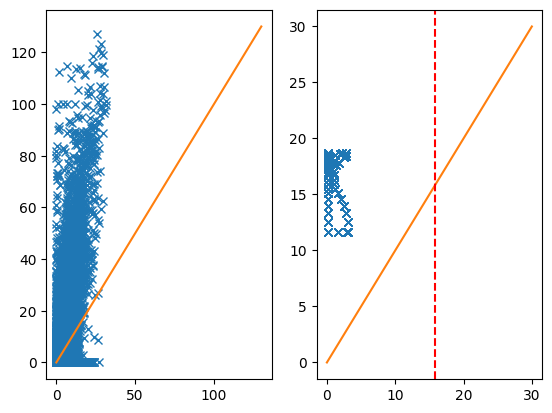

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.656  0.330E+00    31968   149.67  0.585   [Radiance 1.240 micron]
     1  -0.639  0.332E+00    31968   149.58  0.584   [Radiance 2.130 micron]
     1  -0.680  0.264E+00    31968   149.62  0.584   [Radiance 0.660 micron]
     1  -0.638  0.351E+00    31968   149.67  0.585   [Radiance 1.640 micron]
     2  -1.163  0.386E+00    31968   149.67  0.585   [Radiance 1.240 micron]
     2  -1.218  0.307E+00    31968   149.62  0.584   [Radiance 0.660 micron]
     2  -1.161  0.423E+00    31968   149.67  0.585   [Radiance 1.640 micron]
     2  -1.205  0.380E+00    31968   149.58  0.584   [Radiance 2.130 micron]
     3  -1.669  0.326E+00    31968   149.62  0.584   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

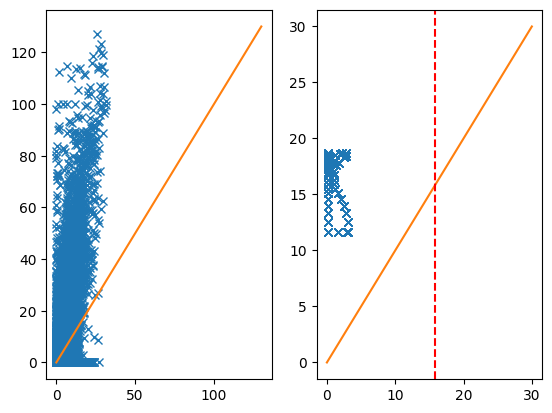

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     1  -0.680  0.264E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.656  0.330E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.639  0.332E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     2  -1.163  0.386E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.218  0.307E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.205  0.380E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     3  -1.622  0.459E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

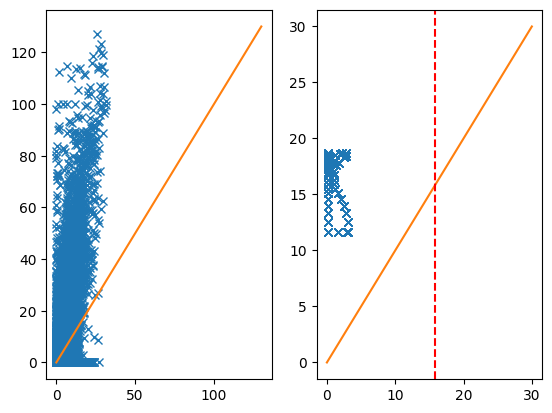

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.680  0.264E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.656  0.330E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     1  -0.639  0.332E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.218  0.307E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.163  0.386E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.205  0.380E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     3  -1.669  0.326E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

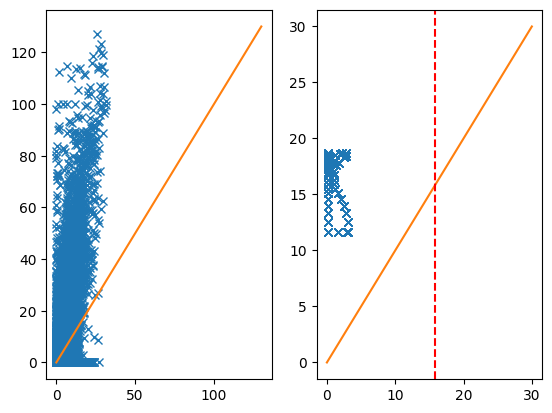

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.264E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.656  0.330E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     1  -0.639  0.332E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.218  0.307E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.161  0.423E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     2  -1.163  0.386E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.205  0.380E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     3  -1.669  0.326E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

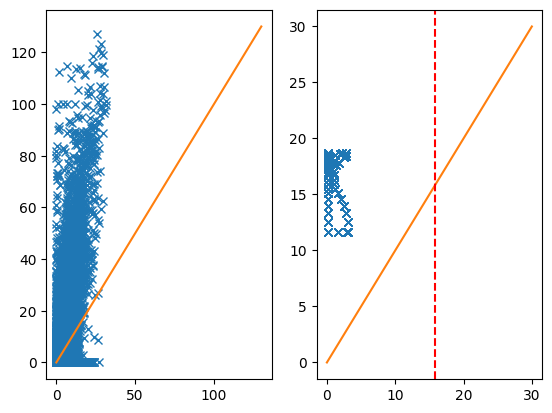

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.264E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     1  -0.656  0.330E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     1  -0.638  0.351E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     1  -0.639  0.332E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.218  0.307E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     2  -1.163  0.386E+00    31968   146.48  0.572   [Radiance 1.240 micron]
     2  -1.205  0.380E+00    31968   146.48  0.572   [Radiance 2.130 micron]
     2  -1.161  0.423E+00    31968   146.48  0.572   [Radiance 1.640 micron]
     3  -1.669  0.326E+00    31968   146.48  0.572   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

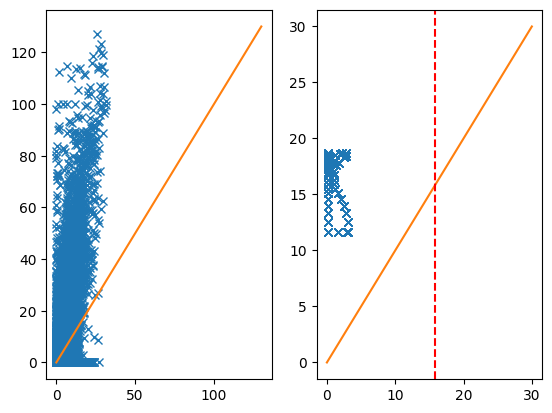


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.686  0.261E+00    31968    98.15  0.383   [Radiance 0.660 micron]
     1  -0.664  0.364E+00    31968    98.15  0.383   [Radiance 1.240 micron]
     1  -0.657  0.338E+00    31968    98.15  0.383   [Radiance 2.130 micron]
     1  -0.651  0.365E+00    31968    98.15  0.383   [Radiance 1.640 micron]
     2  -1.237  0.287E+00    31968    98.15  0.383   [Radiance 0.660 micron]
     2  -1.158  0.437E+00    31968    98.15  0.383   [Radiance 1.240 micron]
     2  -1.143  0.442E+00    31968    98.15  0.383   [Radiance 1.640 micron]
     2  -1.179  0.398E+00    31968    98.15  0.383   [Radiance 2.130 micron]
     3  -1.701  0.292E+00    31968    98.15  0.383   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

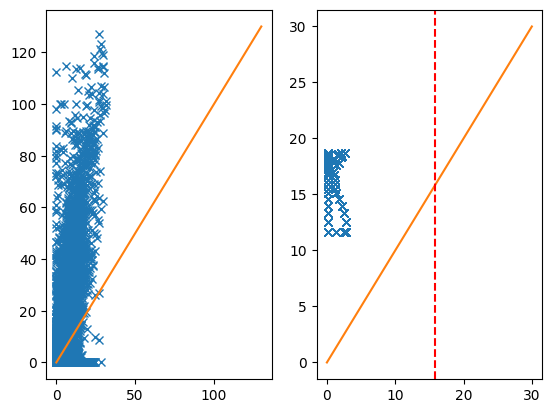


At iterate   25    f=  4.11046D+04    |proj g|=  3.95685D+00


<Figure size 640x480 with 0 Axes>

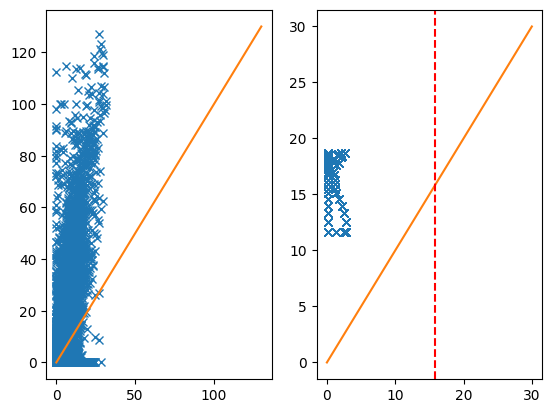

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.651  0.334E+00    31968   125.34  0.490   [Radiance 1.240 micron]
     1  -0.683  0.276E+00    31968   125.34  0.490   [Radiance 0.660 micron]
     1  -0.634  0.357E+00    31968   125.34  0.490   [Radiance 1.640 micron]
     1  -0.637  0.346E+00    31968   125.34  0.490   [Radiance 2.130 micron]
     2  -1.148  0.388E+00    31968   125.34  0.490   [Radiance 1.240 micron]
     2  -1.219  0.330E+00    31968   125.34  0.490   [Radiance 0.660 micron]
     2  -1.195  0.407E+00    31968   125.34  0.490   [Radiance 2.130 micron]
     2  -1.144  0.419E+00    31968   125.34  0.490   [Radiance 1.640 micron]
     3  -1.534  0.409E+00    31968   125.34  0.490   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

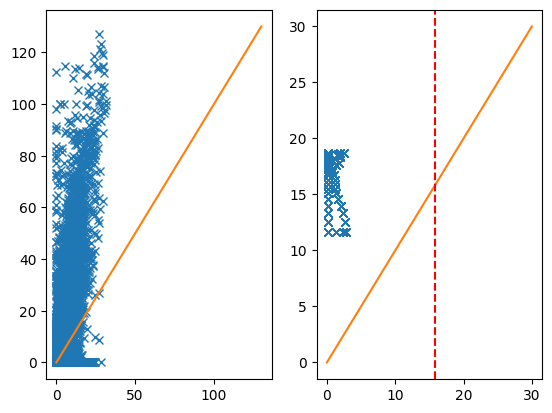


At iterate   26    f=  3.77703D+04    |proj g|=  2.90163D+00


<Figure size 640x480 with 0 Axes>

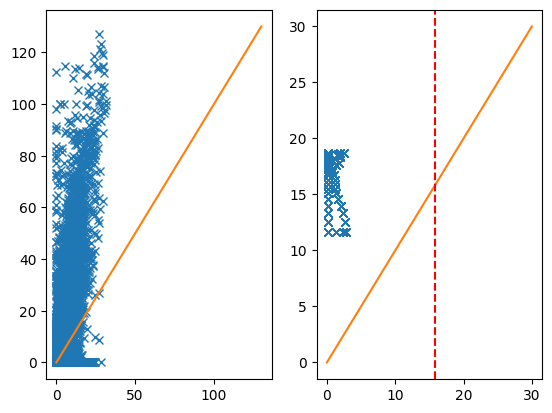

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.679  0.317E+00    31968   123.87  0.484   [Radiance 0.660 micron]
     1  -0.643  0.333E+00    31968   123.87  0.484   [Radiance 1.240 micron]
     1  -0.625  0.374E+00    31968   123.87  0.484   [Radiance 1.640 micron]
     1  -0.625  0.356E+00    31968   123.87  0.484   [Radiance 2.130 micron]
     2  -1.220  0.382E+00    31968   123.87  0.484   [Radiance 0.660 micron]
     2  -1.137  0.386E+00    31968   123.87  0.484   [Radiance 1.240 micron]
     2  -1.176  0.417E+00    31968   123.87  0.484   [Radiance 2.130 micron]
     2  -1.127  0.438E+00    31968   123.87  0.484   [Radiance 1.640 micron]
     3  -1.652  0.409E+00    31968   123.87  0.484   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

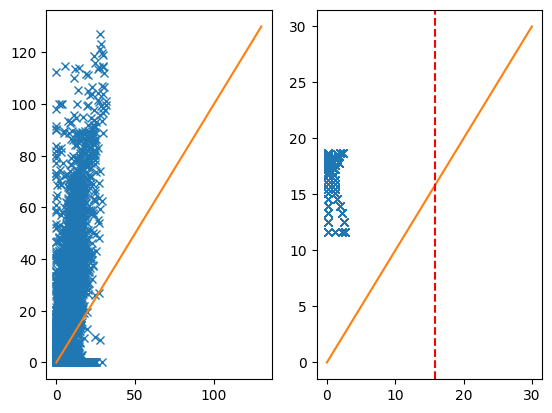


At iterate   27    f=  3.58906D+04    |proj g|=  3.23373D+00


<Figure size 640x480 with 0 Axes>

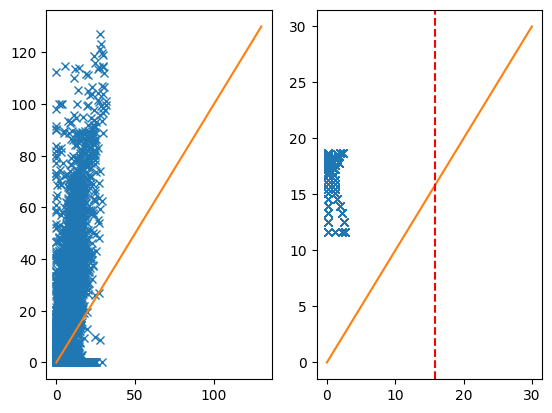

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.677  0.318E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     1  -0.621  0.363E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     1  -0.623  0.392E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     1  -0.644  0.358E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     2  -1.220  0.379E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     2  -1.150  0.405E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     2  -1.135  0.459E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     2  -1.176  0.431E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     3  -1.656  0.404E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

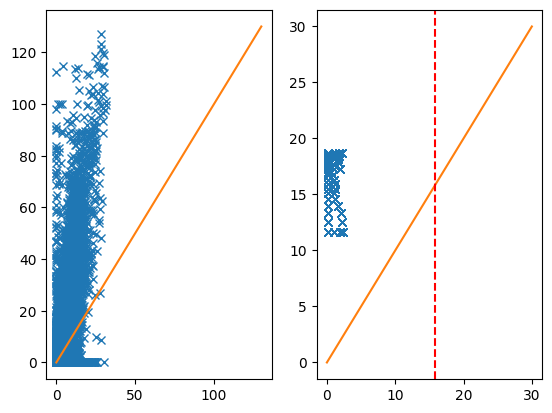


At iterate   28    f=  3.46304D+04    |proj g|=  2.79099D+00


<Figure size 640x480 with 0 Axes>

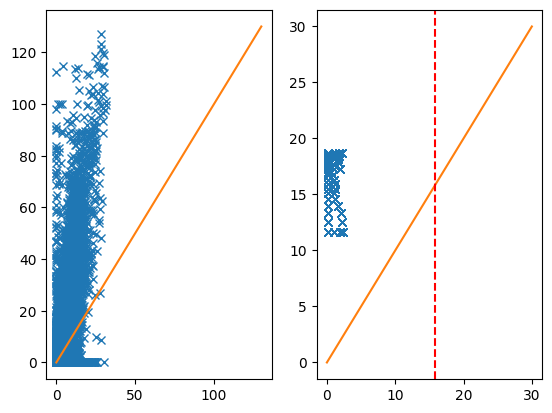

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.681  0.312E+00    31968   122.65  0.479   [Radiance 0.660 micron]
     1  -0.625  0.363E+00    31968   122.65  0.479   [Radiance 2.130 micron]
     1  -0.623  0.394E+00    31968   122.65  0.479   [Radiance 1.640 micron]
     1  -0.642  0.369E+00    31968   122.65  0.479   [Radiance 1.240 micron]
     2  -1.232  0.358E+00    31968   122.65  0.479   [Radiance 0.660 micron]
     2  -1.194  0.431E+00    31968   122.65  0.479   [Radiance 2.130 micron]
     2  -1.146  0.468E+00    31968   122.65  0.479   [Radiance 1.640 micron]
     2  -1.153  0.426E+00    31968   122.65  0.479   [Radiance 1.240 micron]
     3  -1.669  0.377E+00    31968   122.65  0.479   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

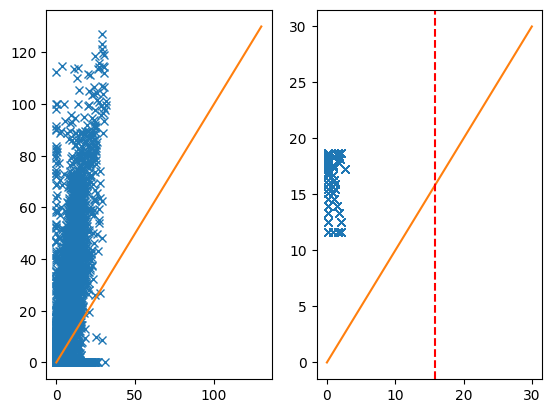

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.677  0.318E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     1  -0.621  0.363E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     1  -0.644  0.358E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     1  -0.623  0.392E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     2  -1.220  0.379E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     2  -1.176  0.431E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     2  -1.135  0.459E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     2  -1.150  0.405E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     3  -1.656  0.404E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

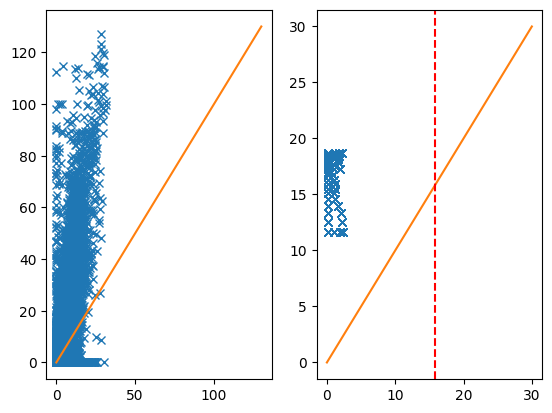

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.622  0.394E+00    31968   131.50  0.514   [Radiance 1.640 micron]
     1  -0.623  0.364E+00    31968   131.50  0.514   [Radiance 2.130 micron]
     1  -0.643  0.364E+00    31968   131.50  0.514   [Radiance 1.240 micron]
     1  -0.679  0.311E+00    31968   131.50  0.514   [Radiance 0.660 micron]
     2  -1.144  0.466E+00    31968   131.50  0.514   [Radiance 1.640 micron]
     2  -1.189  0.432E+00    31968   131.50  0.514   [Radiance 2.130 micron]
     2  -1.229  0.369E+00    31968   131.50  0.514   [Radiance 0.660 micron]
     2  -1.155  0.420E+00    31968   131.50  0.514   [Radiance 1.240 micron]
     3  -1.588  0.494E+00    31968   131.50  0.514   [Radiance 1.640 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

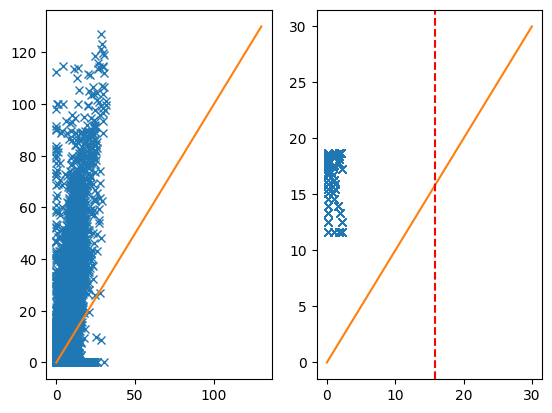

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.642  0.358E+00    31968   131.50  0.514   [Radiance 1.240 micron]
     1  -0.677  0.317E+00    31968   131.50  0.514   [Radiance 0.660 micron]
     1  -0.620  0.392E+00    31968   131.50  0.514   [Radiance 1.640 micron]
     1  -0.618  0.363E+00    31968   131.50  0.514   [Radiance 2.130 micron]
     2  -1.220  0.379E+00    31968   131.50  0.514   [Radiance 0.660 micron]
     2  -1.149  0.406E+00    31968   131.50  0.514   [Radiance 1.240 micron]
     2  -1.135  0.460E+00    31968   131.50  0.514   [Radiance 1.640 micron]
     2  -1.177  0.431E+00    31968   131.50  0.514   [Radiance 2.130 micron]
     3  -1.656  0.403E+00    31968   131.50  0.514   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

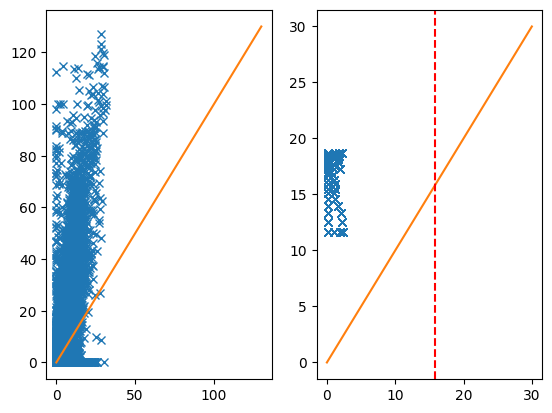

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.677  0.318E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     1  -0.621  0.363E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     1  -0.644  0.358E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     1  -0.623  0.392E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     2  -1.220  0.379E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     2  -1.176  0.431E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     2  -1.150  0.405E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     2  -1.135  0.459E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     3  -1.656  0.404E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

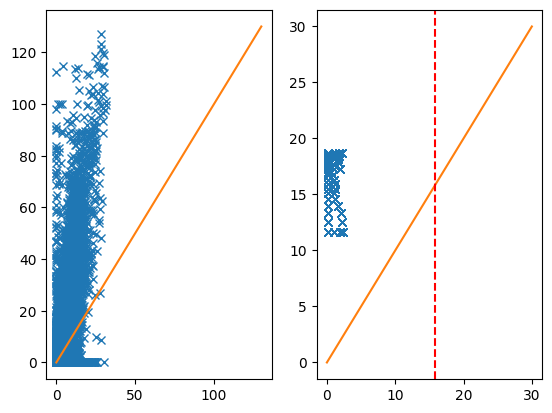


At iterate   29    f=  3.46304D+04    |proj g|=          NaN


<Figure size 640x480 with 0 Axes>

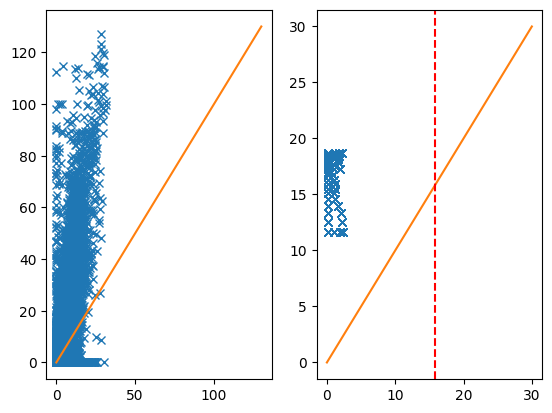

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.629  0.280E+00    31968    41.40  0.162   [Radiance 1.240 micron]
     1  -0.614  0.485E+00    31968    41.41  0.162   [Radiance 0.660 micron]
     1  -0.677  0.858E-01    31968    41.39  0.162   [Radiance 1.640 micron]
     1  -0.826  0.218E-01    31968    41.38  0.162   [Radiance 2.130 micron]
     2  -1.577  0.279E+00    31968    41.40  0.162   [Radiance 1.240 micron]
     2  -1.374  0.486E+00    31968    41.41  0.162   [Radiance 0.660 micron]
     2  -1.858  0.832E-01    31968    41.40  0.162   [Radiance 1.640 micron]
     2  -2.322  0.191E-01    31968    41.39  0.162   [Radiance 2.130 micron]
     3  -2.212  0.278E+00    31968    41.40  0.162   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

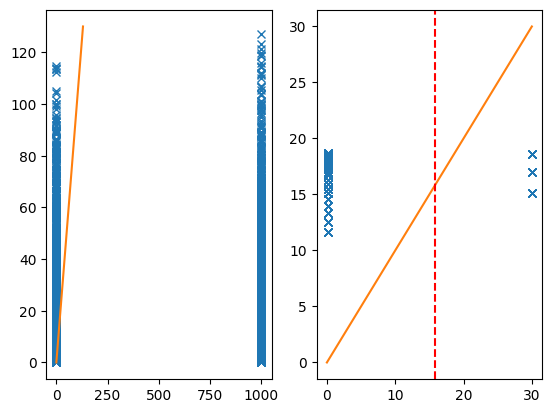

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.677  0.318E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     1  -0.621  0.363E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     1  -0.644  0.358E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     1  -0.623  0.392E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     2  -1.220  0.379E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     2  -1.150  0.405E+00    31968   124.77  0.487   [Radiance 1.240 micron]
     2  -1.176  0.431E+00    31968   124.77  0.487   [Radiance 2.130 micron]
     2  -1.135  0.459E+00    31968   124.77  0.487   [Radiance 1.640 micron]
     3  -1.656  0.404E+00    31968   124.77  0.487   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

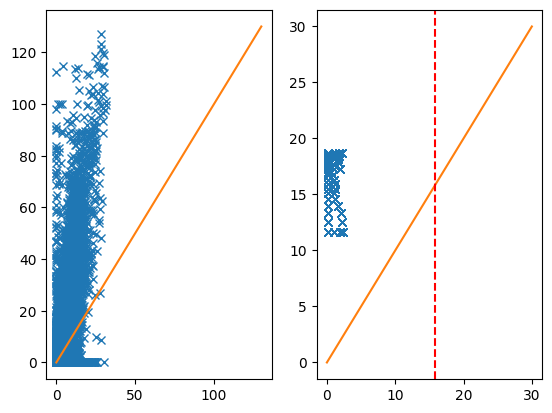


At iterate   30    f=  3.46304D+04    |proj g|=  2.79099D+00


<Figure size 640x480 with 0 Axes>

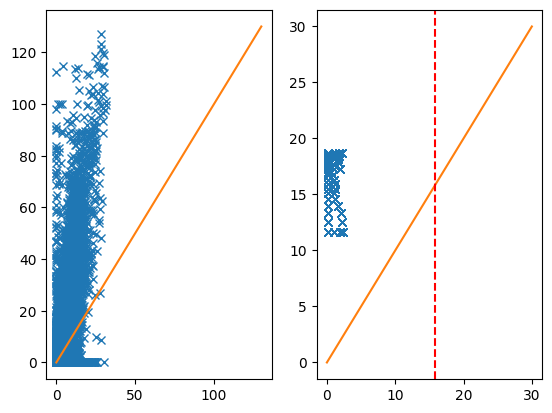


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377     30     70  85706     0 28373   2.791D+00   3.463D+04
  F =   34630.387179491918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [12]:
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 100
result = optimizer.minimize(x0)

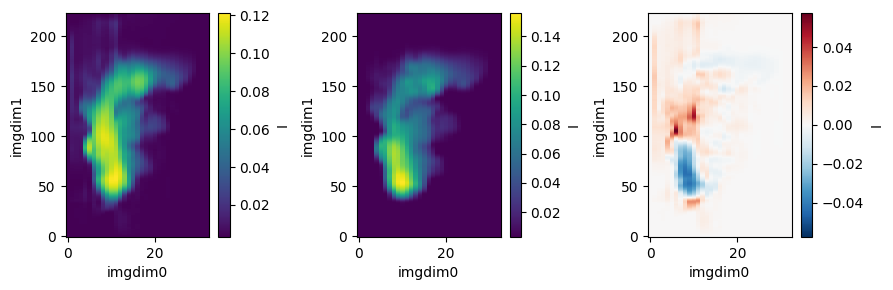

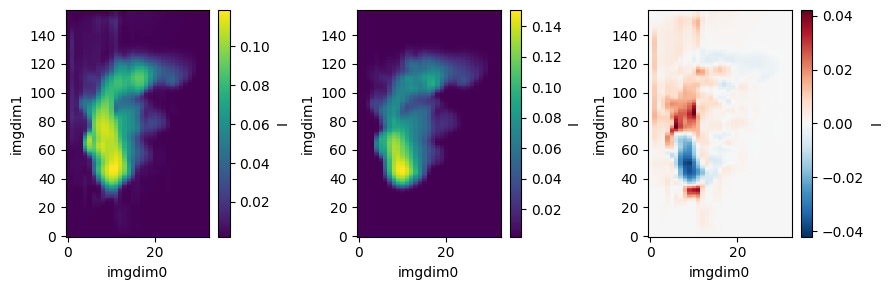

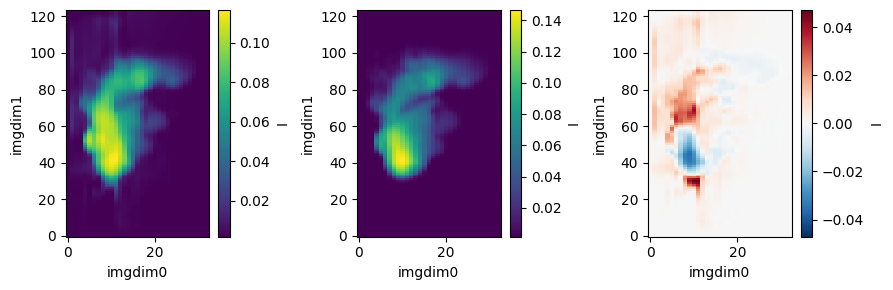

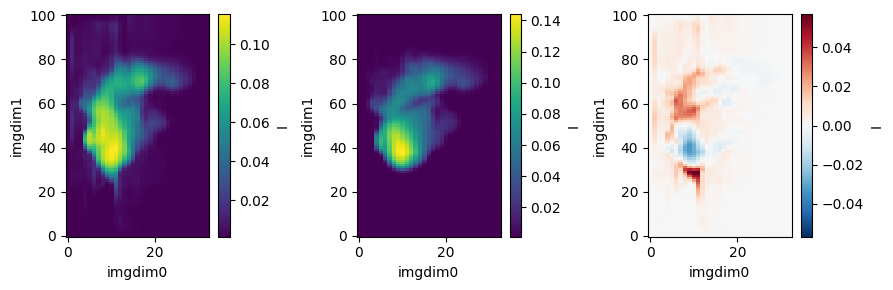

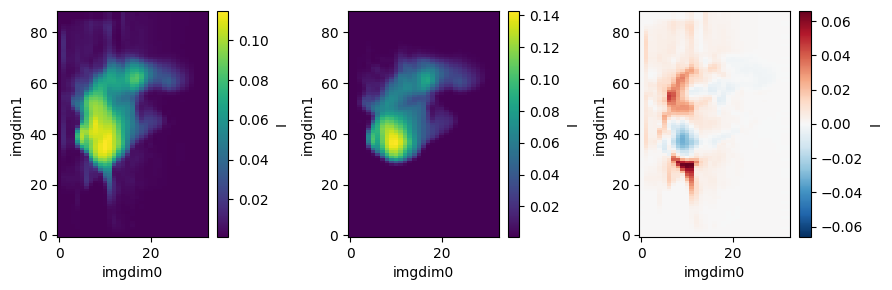

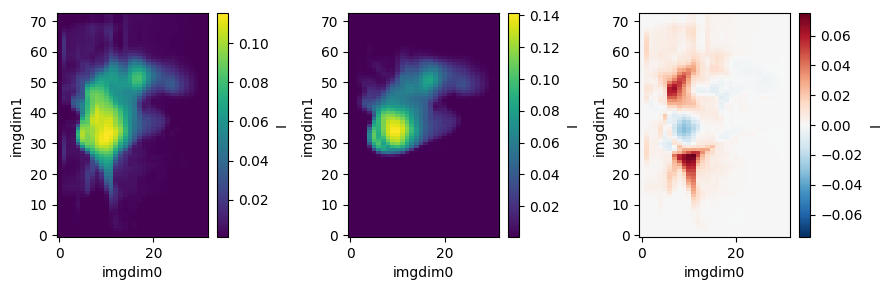

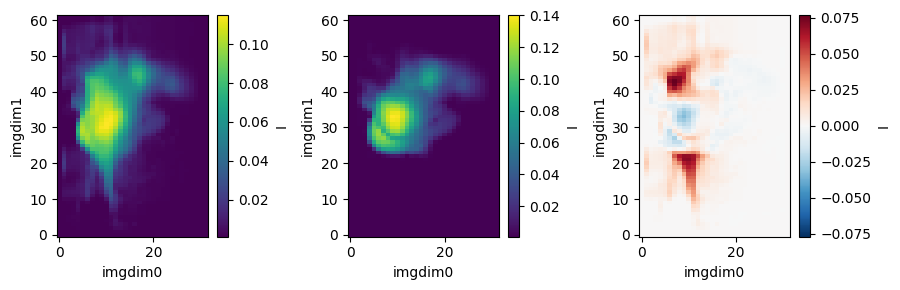

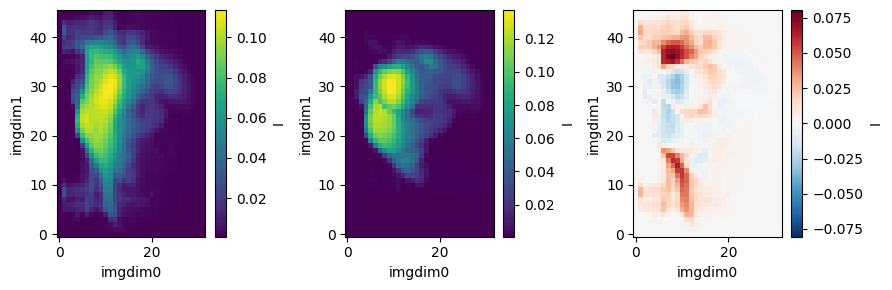

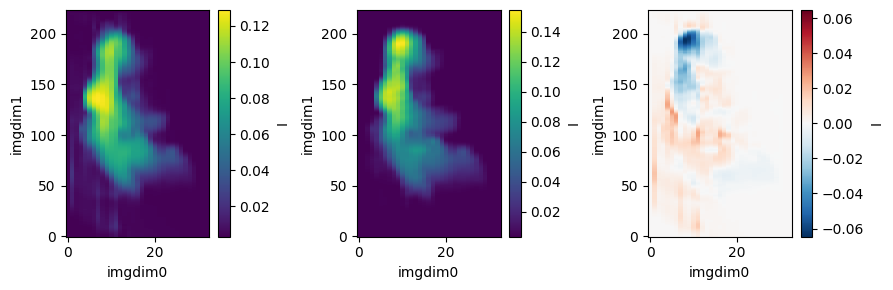

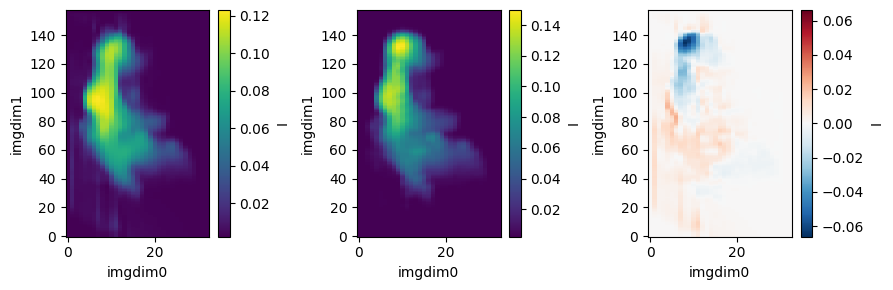

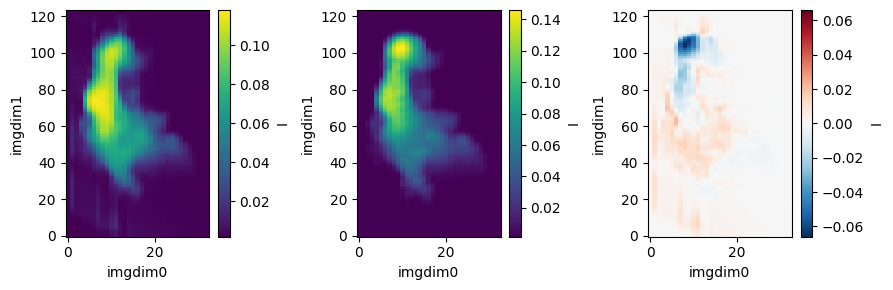

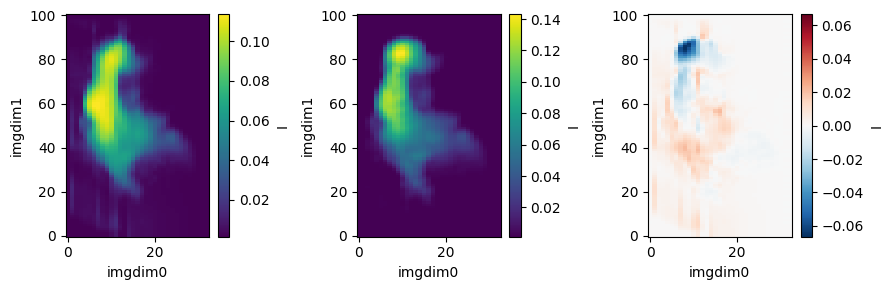

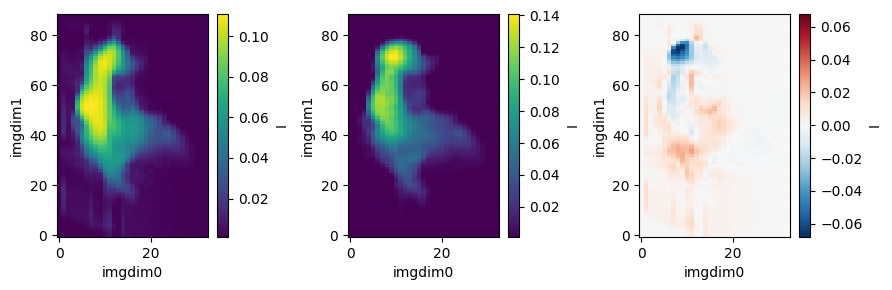

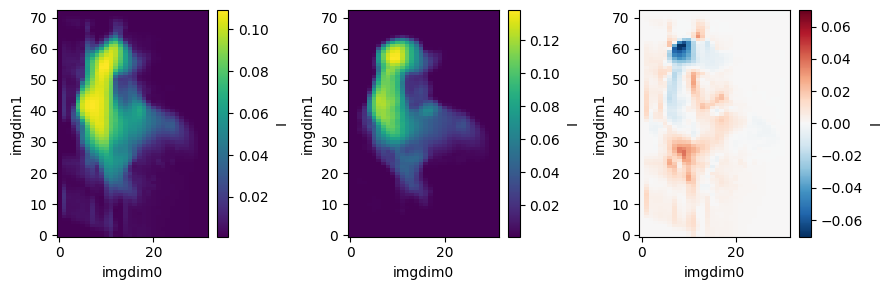

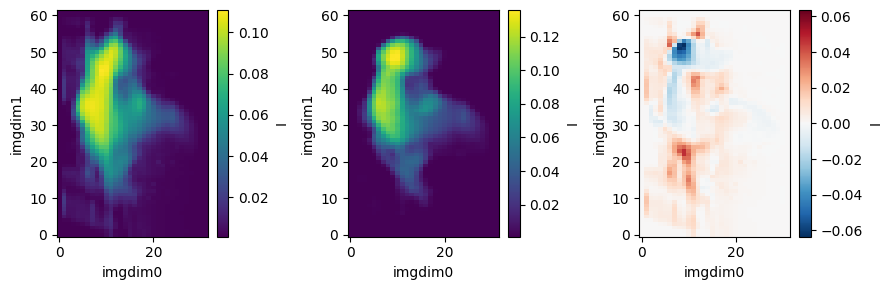

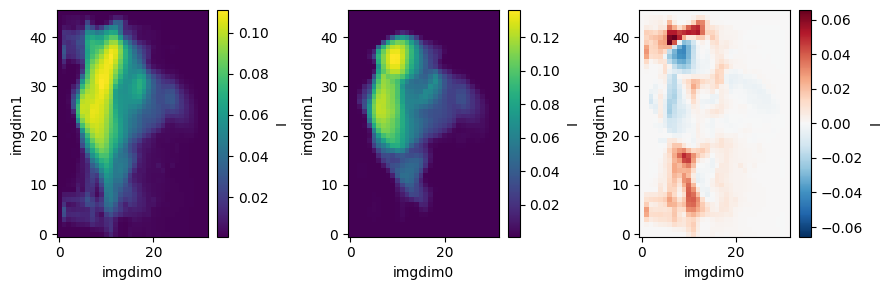

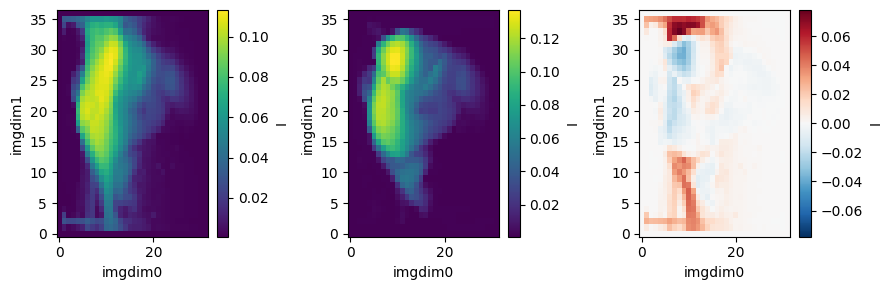

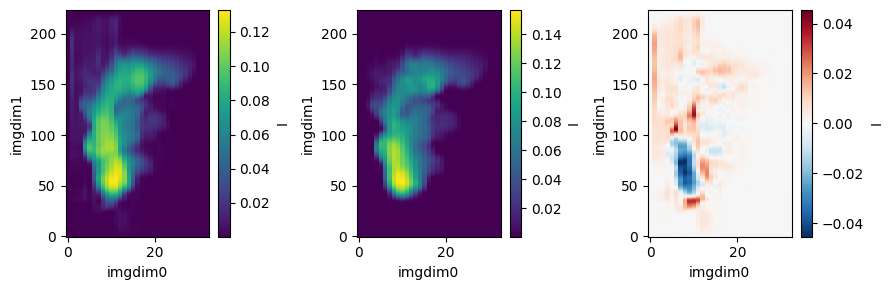

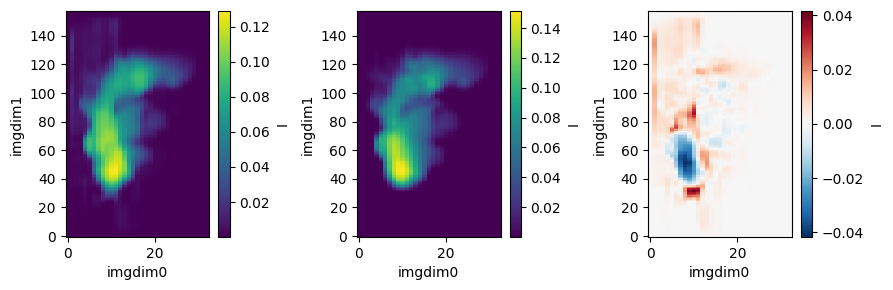

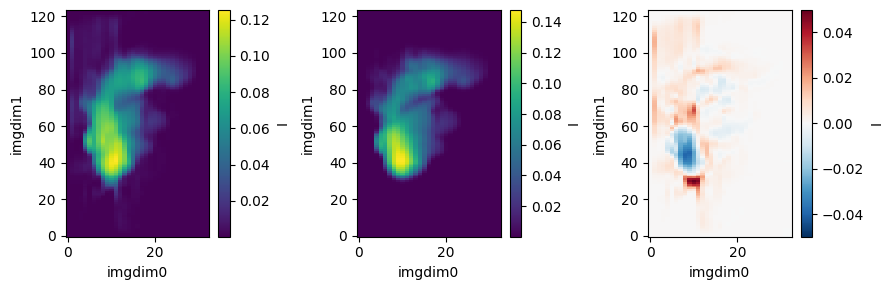

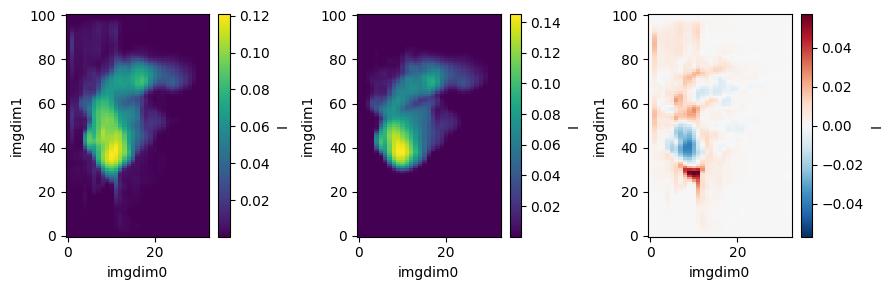

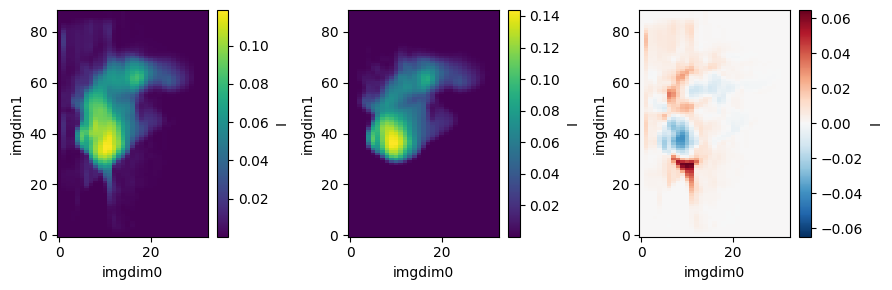

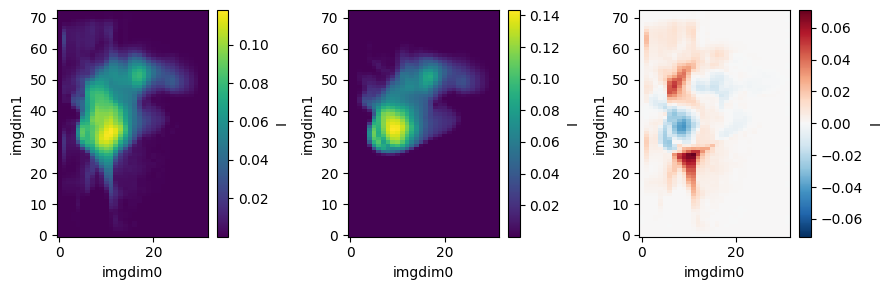

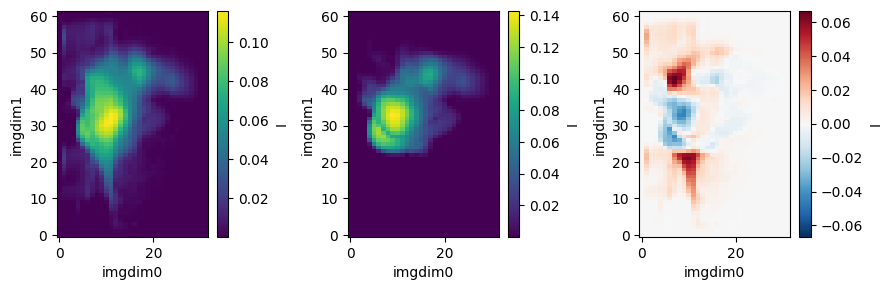

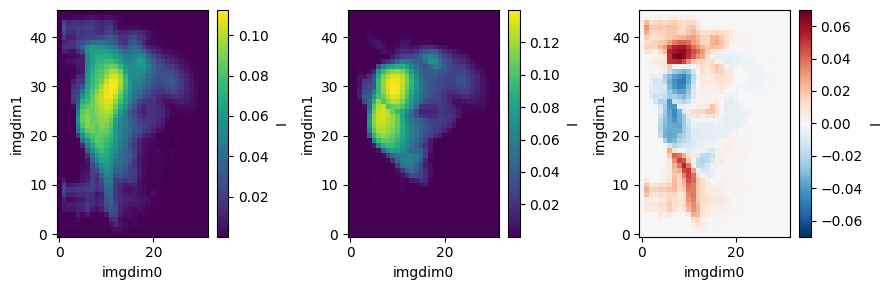

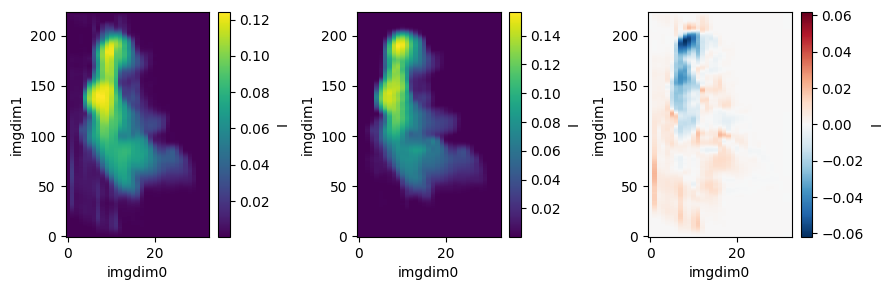

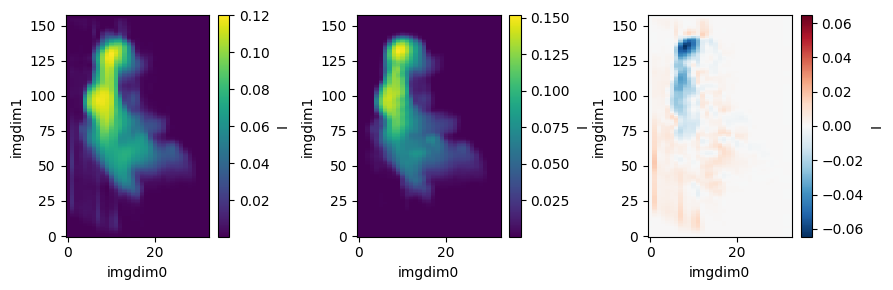

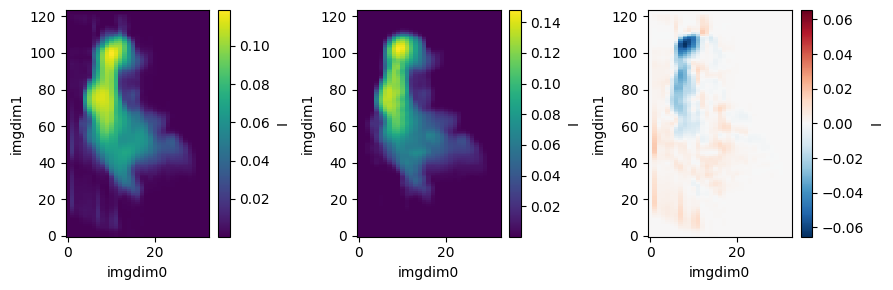

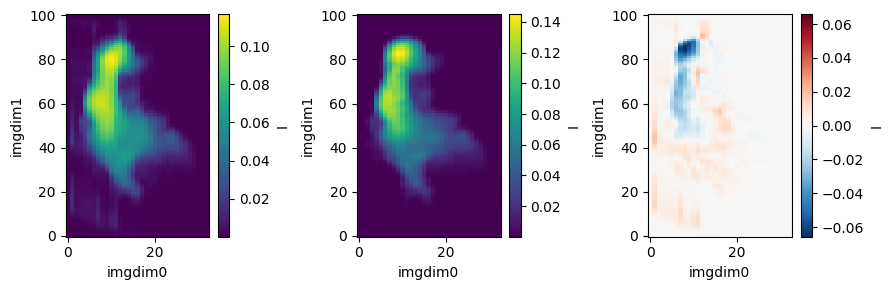

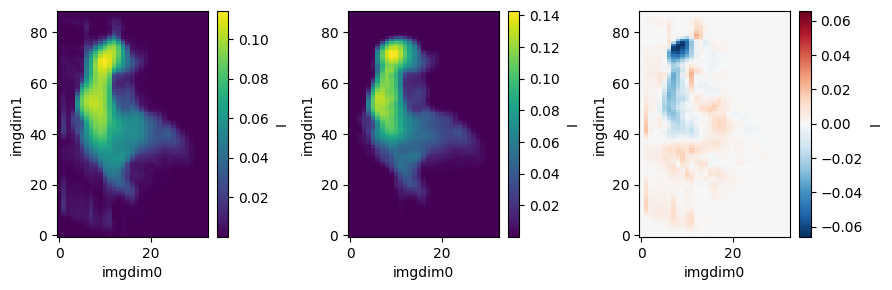

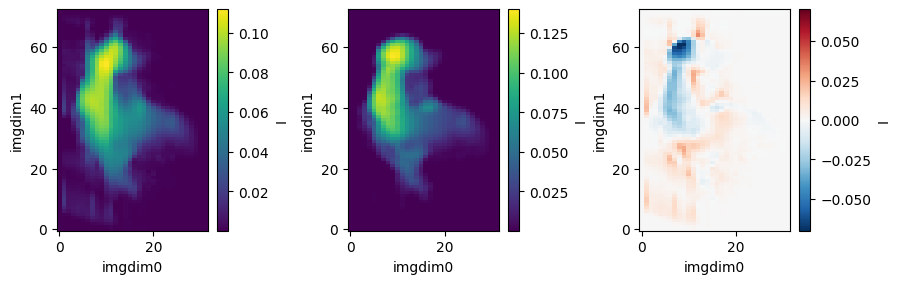

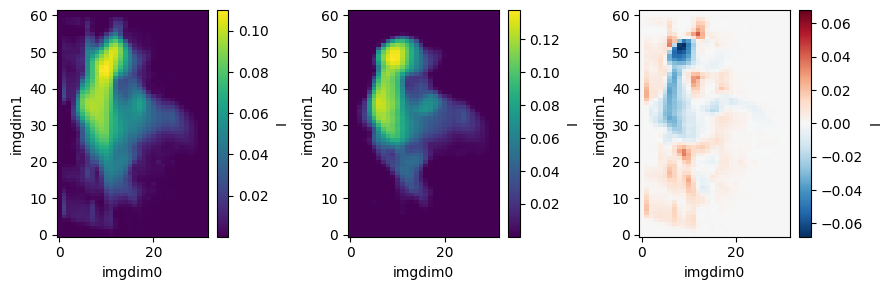

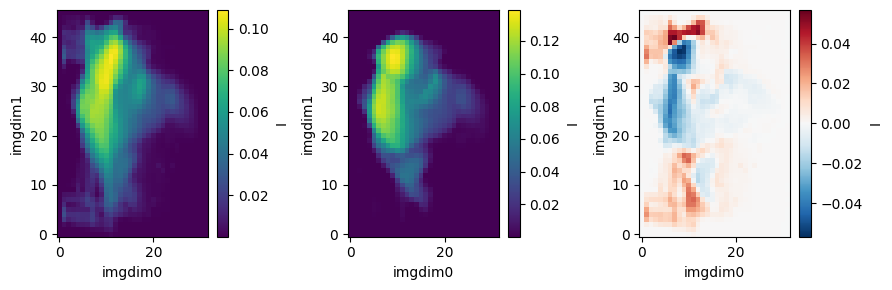

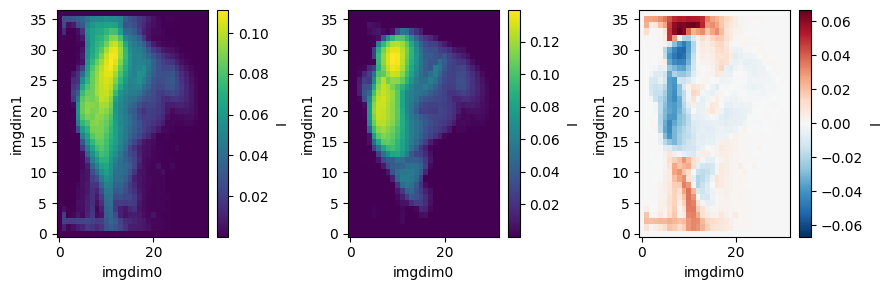

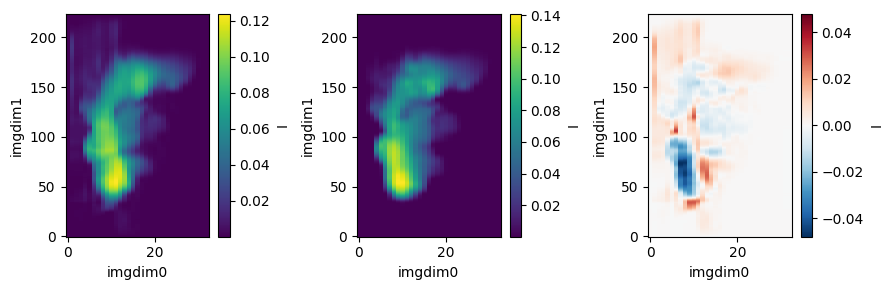

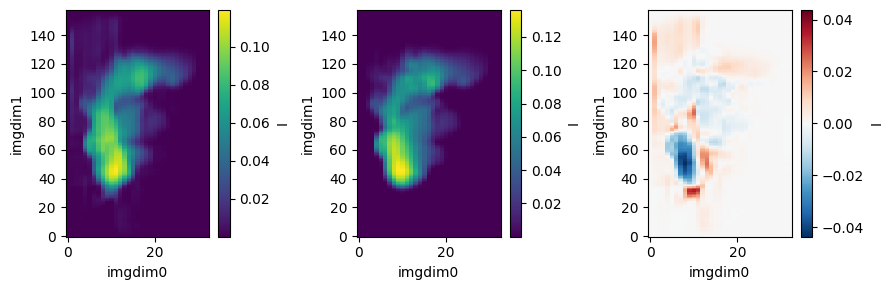

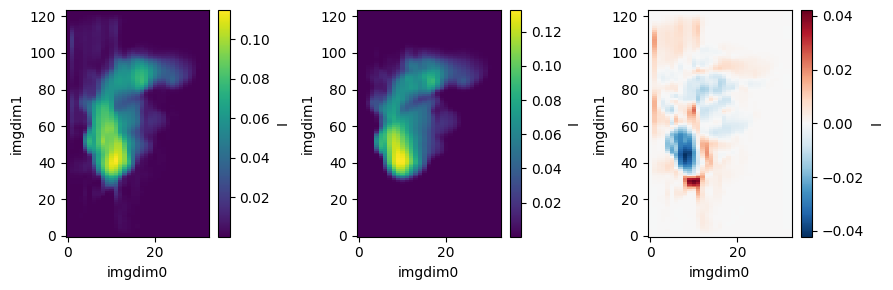

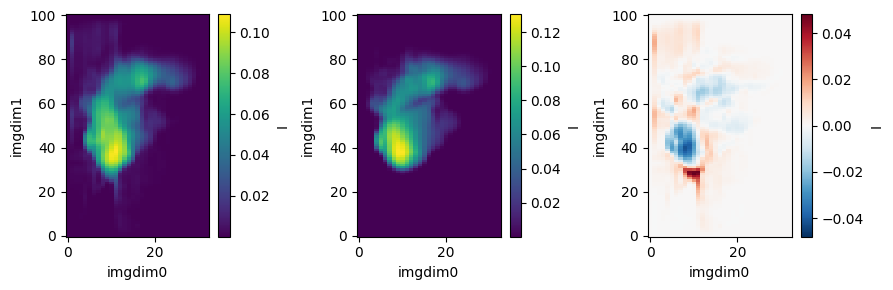

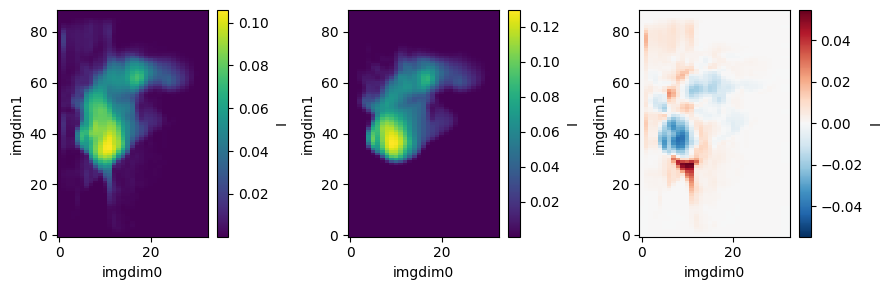

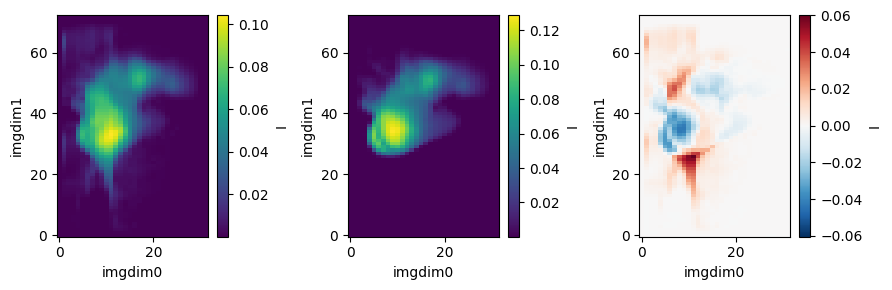

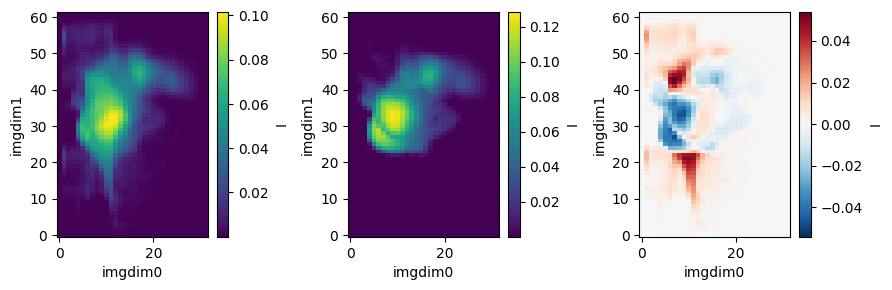

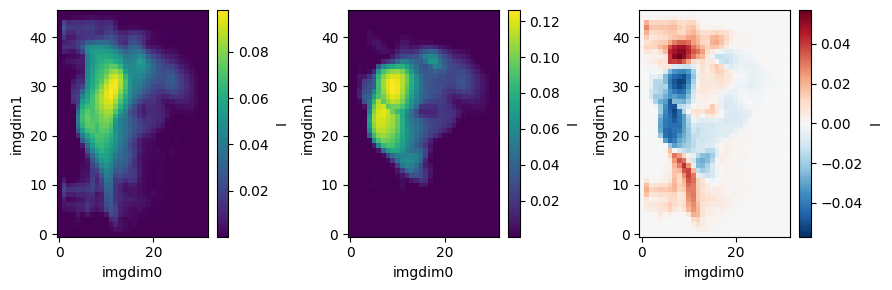

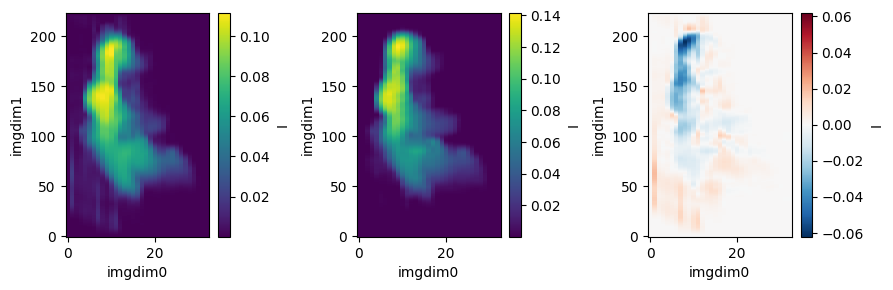

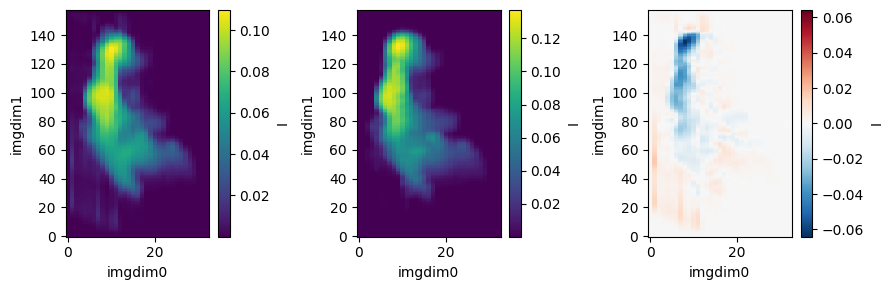

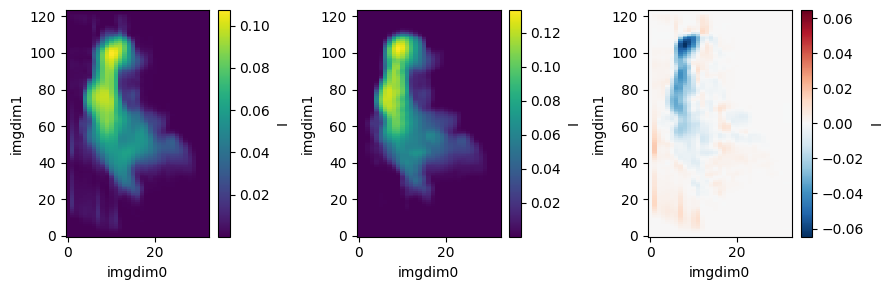

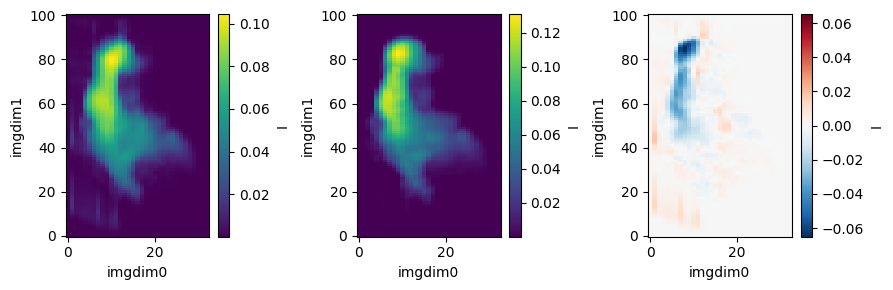

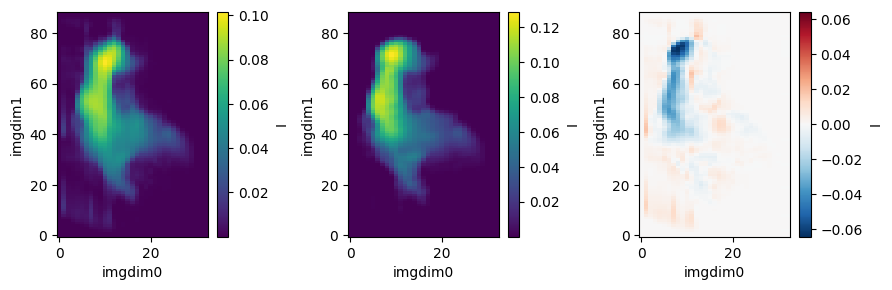

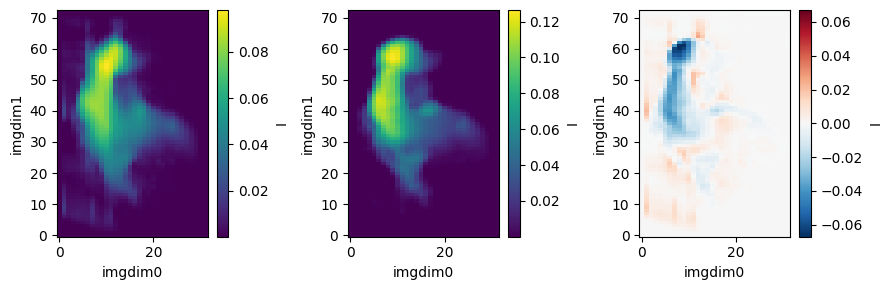

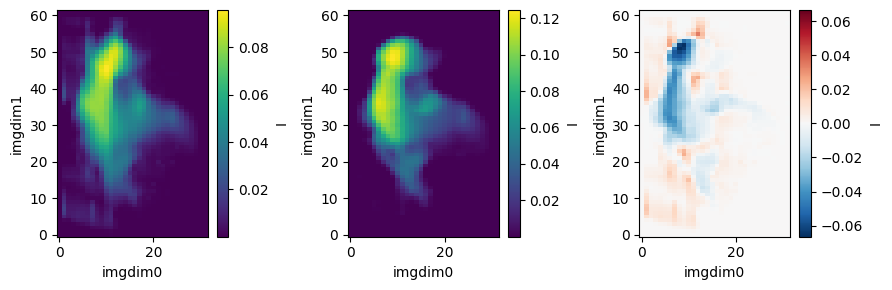

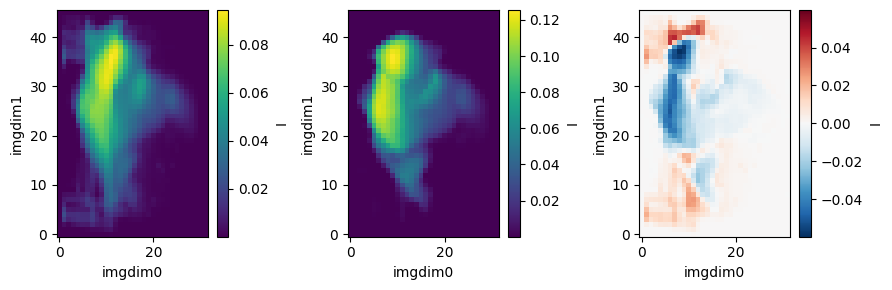

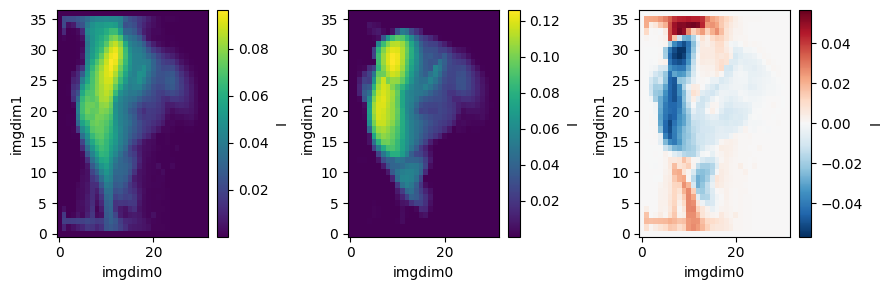

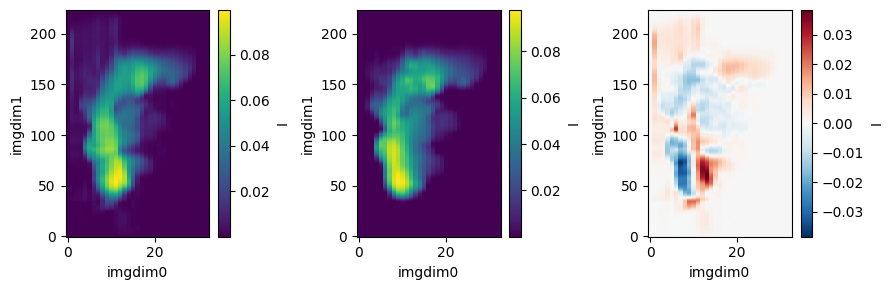

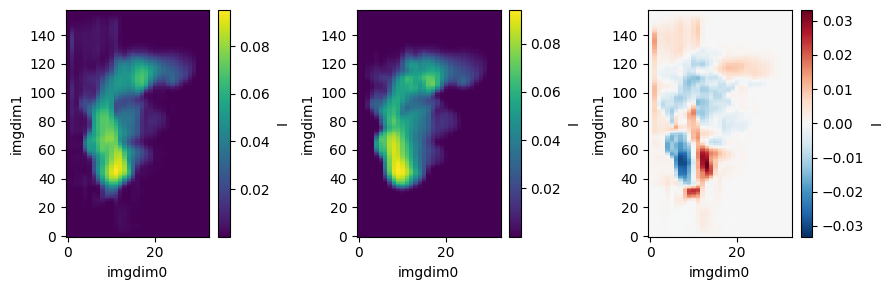

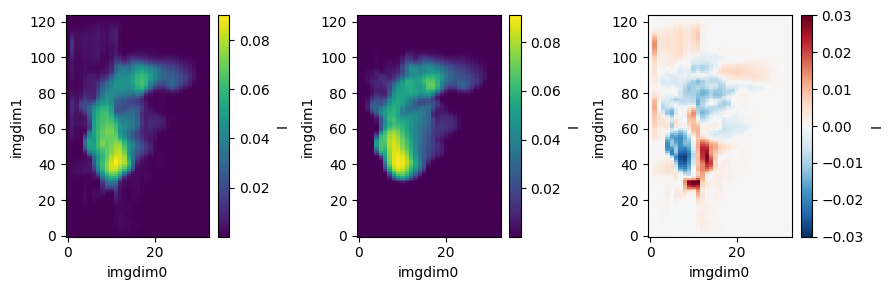

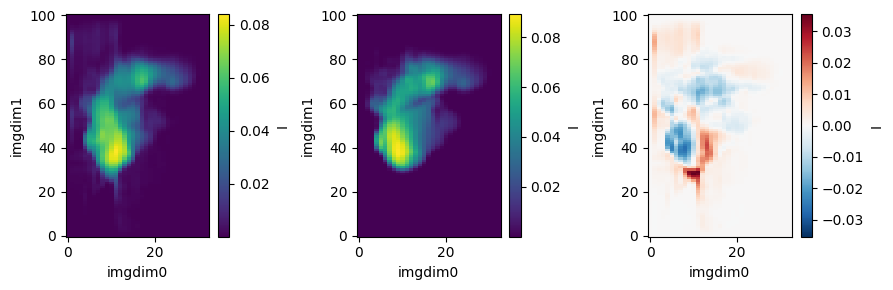

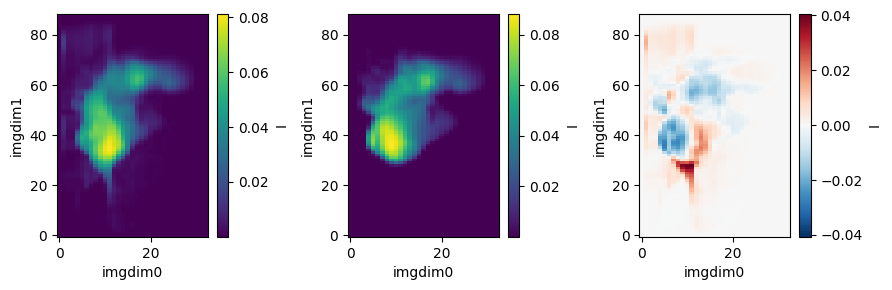

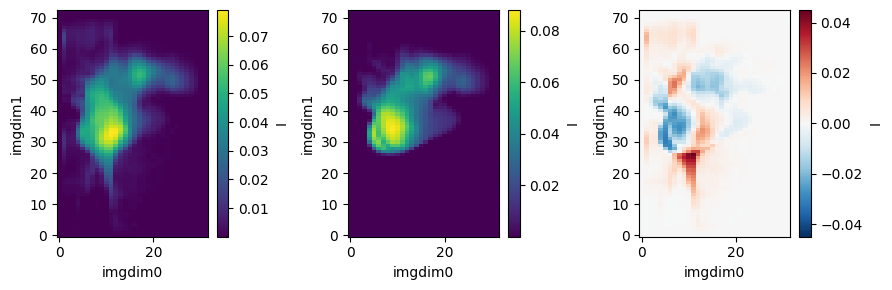

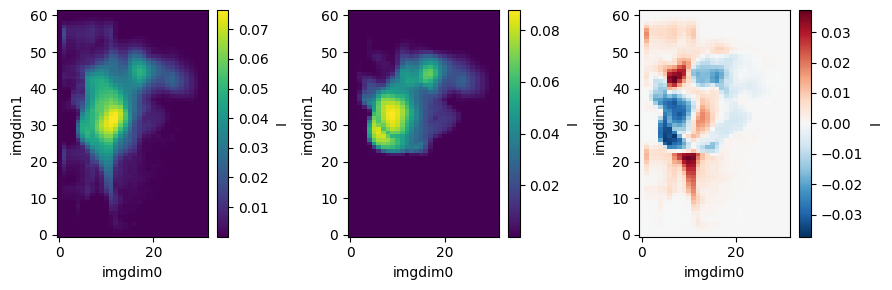

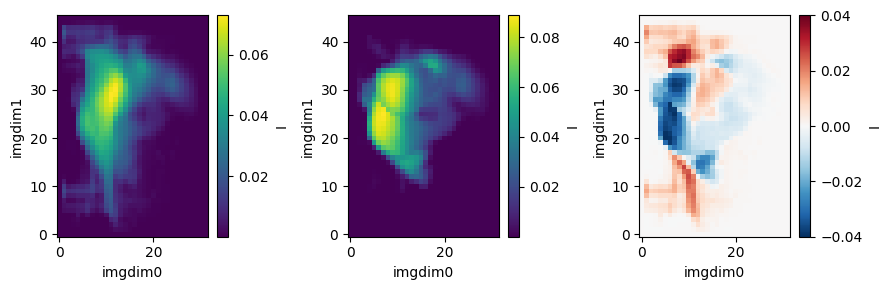

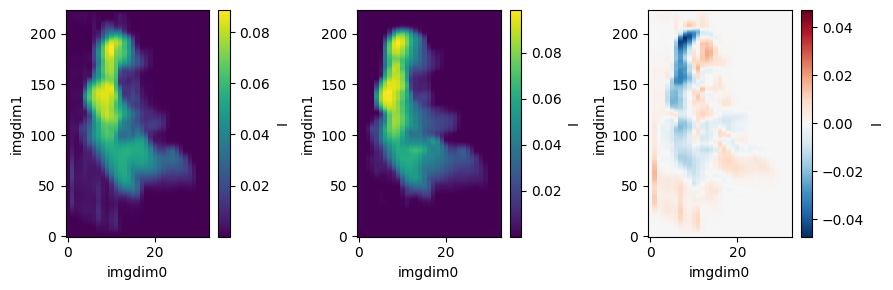

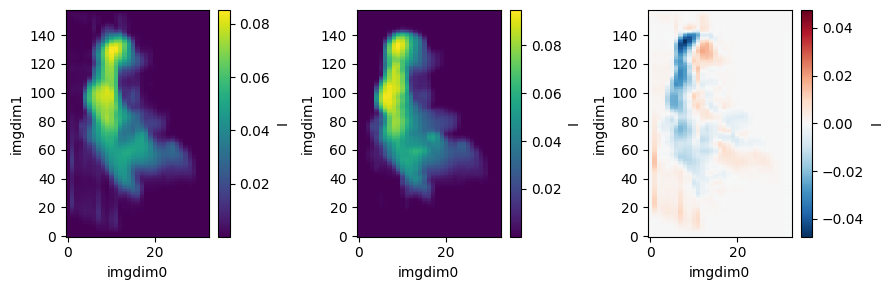

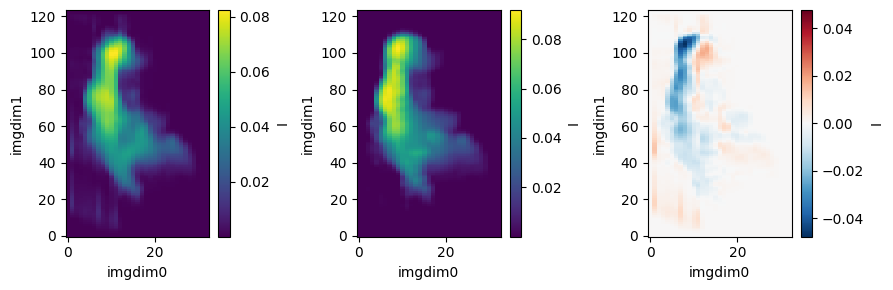

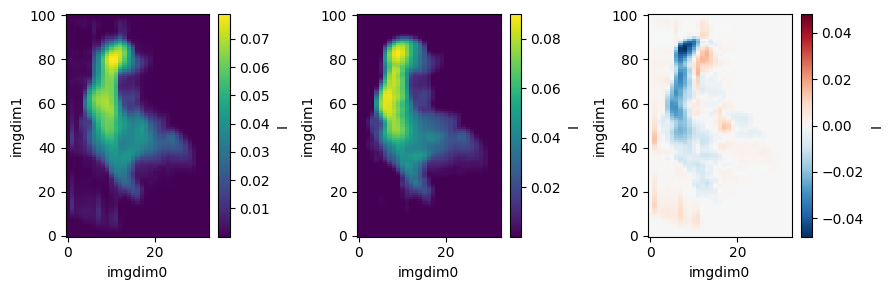

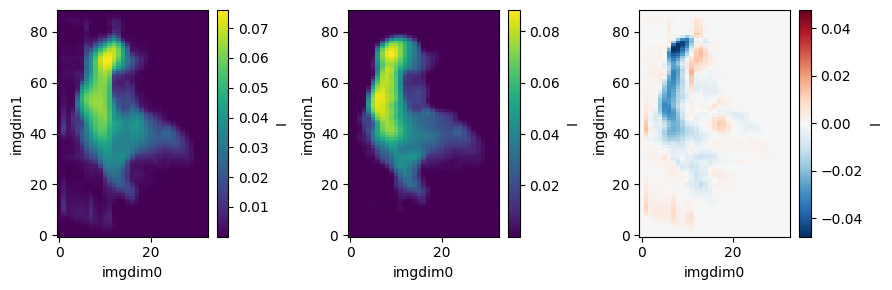

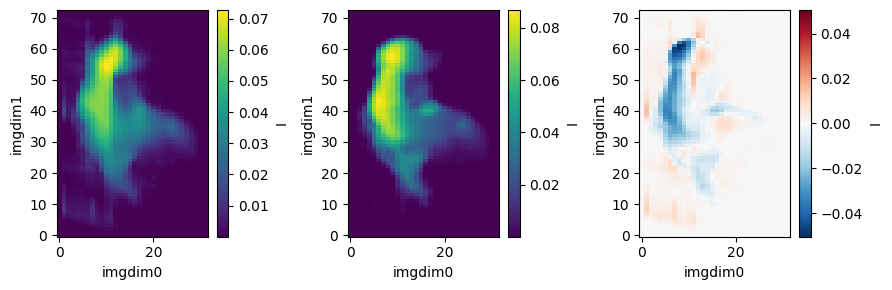

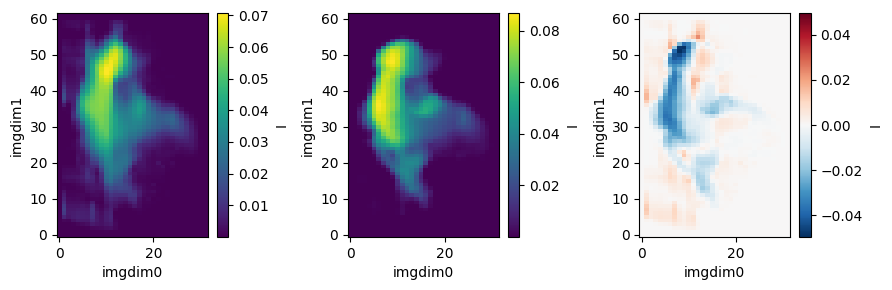

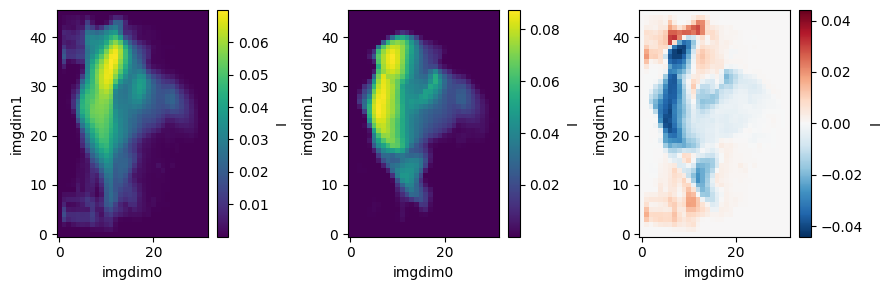

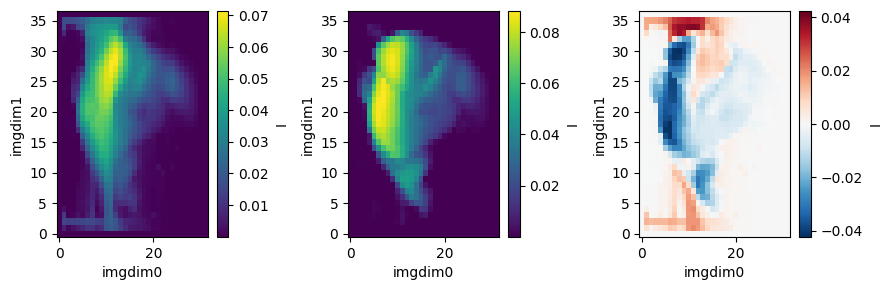

In [16]:
%matplotlib inline
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3, figsize=(9, 3))
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])
        fig.tight_layout()
        py.show()